# **Pemantauan dan Prediksi Banjir Berbasis Curah Hujan di Kabupaten Cilacap**
#### Projek ini merupakan tugas akhir dari pelatihan TSA DTS Kominfo 2023 yang dibuat oleh kelompok 4. Dengan berfokus pada forecast data curah hujan dan prediksi kejadian banjir, diharapkan dapat memberikan kontribusi signifikan dalam upaya pencegahan dan mitigasi dampak banjir di Kabupaten Cilacap.

## Daftar Isi


Daftar isi untuk projek ini adalah sebagai berikut:-

1. Pernyataan masalah
2. Mengimport libraries
3. Mengimport dataset
4. Data Pre-processing
5. Exploratory data analysis
6. Modelling
    -	6.1 Exponential Smoothing
7. Validasi Model
8. Forecast
9. Save Model

## 1. Pernyataan masalah <a class="anchor" id="1"></a>

Pada tahap sebelumnya, tim telah berhasil melakukan preprocessing pada data mentah. Kini, data yang telah diolah akan menjadi dasar dalam pembuatan model untuk melakukan forecast curah hujan di beberapa interval waktu kedepan di Kabupaten Cilacap. Tujuan utama dari model ini dalam konteks proyek ini adalah memberikan informasi yang dapat digunakan untuk mengantisipasi dan mengurangi risiko banjir di Kabupaten Cilacap. Dengan memahami pola curah hujan, dapat dilakukan tindakan preventif lebih efektif dan tepat waktu.

## 2. Mengimport libraries <a class="anchor" id="2"></a>
Sebelum memulai tahap analisis, langkah awal yang kami lakukan adalah mengimpor berbagai libraries yang akan digunakan dalam projek ini.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import os
import pickle

import warnings
warnings.filterwarnings('ignore')

## 3. Mengimport dataset <a class="anchor" id="3"></a>

Langkah berikutnya dalam analisis data ini adalah mengimpor dataset yang telah dipersiapkan sebelumnya. Dataset yang digunakan merupakan gabungan antara data kejadian banjir dari Badan Nasional Penanggulangan Bencana (BNPB) dan data curah hujan harian di Kabupaten Cilacap yang diperoleh dari World Weather Online. Rentang data yang digunakan adalah dari Januari 2020 hingga Februari 2023, dan satuan untuk curah hujan yang dicatat adalah dalam milimeter (mm).

Sumber data original kejadian banjir dari Badan Nasional Penanggulangan Bencana (BNPB) dapat diperoleh dari
[https://dibi.bnpb.go.id/](https://dibi.bnpb.go.id/).

Sumber data original curah hujan harian di Kabupaten Cilacap dari World Weather Online dapat diperoleh dari [https://www.worldweatheronline.com/](https://www.worldweatheronline.com/).

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_path = '/content/drive/MyDrive/Tugas DTS TSA/Dashboard Pemantauan dan Prediksi Banjir Kabupaten Cilacap/Dataset/cilacap_final_dataset.csv'

In [ ]:
# Data Historis Curah Hujan di Kabupaten Cilacap
df = pd.read_csv(file_path)
df

date      Kejadian Penyebab  \
0     2020-01-01  Tidak Banjir      NaN   
1     2020-01-02  Tidak Banjir      NaN   
2     2020-01-03        Banjir      NaN   
3     2020-01-04  Tidak Banjir      NaN   
4     2020-01-05        Banjir      NaN   
...          ...           ...      ...   
1126  2023-01-31  Tidak Banjir      NaN   
1127  2023-02-01  Tidak Banjir      NaN   
1128  2023-02-02  Tidak Banjir      NaN   
1129  2023-02-03  Tidak Banjir      NaN   
1130  2023-02-04  Tidak Banjir      NaN   

                                             Keterangan   Lokasi  \
0                                                   NaN  Cilacap   
1                                                   NaN  Cilacap   
2     40 sumur tercemar, Ketinggian air mengenang se...  Cilacap   
3                                                   NaN  Cilacap   
4                                                   NaN  Cilacap   
...                                                 ...      ...   
1126                                                NaN  Cilacap   
1127                                                NaN  Cilacap   
1128                                                NaN  Cilacap   
1129                                                NaN  Cilacap   
1130                                                NaN  Cilacap   

                   Posisi  hujan_0  hujan_300  hujan_600  hujan_900  \
0                     NaN      1.6        0.0        1.5        0.0   
1                     NaN      0.4        0.0        0.0        0.0   
2     -7.64872, 109.15607      0.0        0.0        0.0        0.2   
3                     NaN      0.2        1.1        0.0        0.0   
4     -7.62933, 108.81783      0.2        0.5        0.0        0.0   
...                   ...      ...        ...        ...        ...   
1126                  NaN      0.0        0.0        0.0        0.0   
1127                  NaN      0.0        0.0        0.0        0.0   
1128                  NaN      0.0        0.2        0.1        0.0   
1129                  NaN      0.0        0.4        0.3        0.2   
1130                  NaN      0.0        0.0        0.0        0.1   

      hujan_1200  hujan_1500  hujan_2100  min_hujan  max_hujan  avg_hujan  
0            0.2         0.2         2.1        0.0        2.1   0.800000  
1            0.1         7.8         2.4        0.0        7.8   1.528571  
2            0.1         8.1         1.3        0.0        8.1   1.385714  
3            0.0         0.7         1.3        0.0        1.3   0.471429  
4            1.1         3.0         0.0        0.0        3.0   0.685714  
...          ...         ...         ...        ...        ...        ...  
1126         0.0         6.0         0.1        0.0        6.0   0.871429  
1127         0.1         5.7         2.4        0.0        5.7   1.171429  
1128         0.1         1.2         0.0        0.0        1.2   0.228571  
1129         0.0         0.1         0.0        0.0        0.4   0.142857  
1130         0.2         0.1         0.1        0.0        0.2   0.071429  

[1131 rows x 16 columns]

## 4. Data Pre-processing <a class="anchor" id="4"></a>

In [ ]:
import pandas as pd

df_pp = df.copy()
df_pp = df_pp[['date', 'hujan_0',	'hujan_300',	'hujan_600', 'hujan_900', 'hujan_1200',	'hujan_1500',	'hujan_2100']]

def preprocess_dataframe(df, freq):
    # Melt DataFrame to combine columns 'date' and 'hour' into 'waktu' and 'curah_hujan'
    df = pd.melt(df, id_vars=['date'], var_name='hour', value_name='curah_hujan')

    # Transform 'hour' into a datetime format
    df['hour'] = df['hour'].str.replace('hujan_', '')  # Remove "hujan_"
    df['hour'] = df['hour'].str.pad(width=4, side='left', fillchar='0')  # Pad 'hour' with leading zeros
    df['waktu'] = pd.to_datetime(df['date'] + ' ' + df['hour'], format='%Y-%m-%d %H%M')

    # Sort the DataFrame based on the 'waktu' column in ascending order
    df = df.sort_values(by='waktu', ascending=True)

    # Drop the 'date' and 'hour' columns that are no longer needed
    df = df.drop(columns=['date', 'hour'])

    # Reset the index
    df = df.reset_index(drop=True)

    # Convert the 'waktu' column to datetime format if it's not already
    df['waktu'] = pd.to_datetime(df['waktu'], format='%Y-%m-%d %H:%M:%S')

    # Set the 'waktu' column as the index
    df.set_index('waktu', inplace=True)

    # Check if a resampling frequency is provided
    if freq:
        # Resample the data according to the specified frequency and sum the 'curah_hujan' values
        df = df.resample(freq).mean()
        return df
    else:
        # If resample_freq is empty, return the preprocessed DataFrame without resampling
        return df

# Assuming you have a DataFrame named 'original_df' and want to resample it daily
resampled_df = preprocess_dataframe(df_pp,'M')
resampled_df

curah_hujan
waktu                  
2020-01-31     1.061290
2020-02-29     0.798030
2020-03-31     0.861751
2020-04-30     0.713333
2020-05-31     0.613364
2020-06-30     0.240476
2020-07-31     0.202765
2020-08-31     0.147926
2020-09-30     0.165238
2020-10-31     0.444700
2020-11-30     0.365714
2020-12-31     0.568203
2021-01-31     0.690323
2021-02-28     0.731122
2021-03-31     0.609677
2021-04-30     0.295714
2021-05-31     0.230415
2021-06-30     0.346190
2021-07-31     0.150691
2021-08-31     0.195853
2021-09-30     0.247619
2021-10-31     0.238710
2021-11-30     0.429048
2021-12-31     0.409217
2022-01-31     0.516590
2022-02-28     0.339286
2022-03-31     0.354378
2022-04-30     0.396190
2022-05-31     0.311060
2022-06-30     0.331905
2022-07-31     0.300922
2022-08-31     0.251152
2022-09-30     0.324286
2022-10-31     0.451613
2022-11-30     0.457143
2022-12-31     0.568664
2023-01-31     0.447005
2023-02-28     0.403571

## 5. Exploratory data analysis <a class="anchor" id="5"></a>

In [ ]:
df = df[['date', 'hujan_0',	'hujan_300',	'hujan_600', 'hujan_900', 'hujan_1200',	'hujan_1500',	'hujan_2100',	'min_hujan',	'max_hujan',	'avg_hujan']]
df

date  hujan_0  hujan_300  hujan_600  hujan_900  hujan_1200  \
0     2020-01-01      1.6        0.0        1.5        0.0         0.2   
1     2020-01-02      0.4        0.0        0.0        0.0         0.1   
2     2020-01-03      0.0        0.0        0.0        0.2         0.1   
3     2020-01-04      0.2        1.1        0.0        0.0         0.0   
4     2020-01-05      0.2        0.5        0.0        0.0         1.1   
...          ...      ...        ...        ...        ...         ...   
1126  2023-01-31      0.0        0.0        0.0        0.0         0.0   
1127  2023-02-01      0.0        0.0        0.0        0.0         0.1   
1128  2023-02-02      0.0        0.2        0.1        0.0         0.1   
1129  2023-02-03      0.0        0.4        0.3        0.2         0.0   
1130  2023-02-04      0.0        0.0        0.0        0.1         0.2   

      hujan_1500  hujan_2100  min_hujan  max_hujan  avg_hujan  
0            0.2         2.1        0.0        2.1   0.800000  
1            7.8         2.4        0.0        7.8   1.528571  
2            8.1         1.3        0.0        8.1   1.385714  
3            0.7         1.3        0.0        1.3   0.471429  
4            3.0         0.0        0.0        3.0   0.685714  
...          ...         ...        ...        ...        ...  
1126         6.0         0.1        0.0        6.0   0.871429  
1127         5.7         2.4        0.0        5.7   1.171429  
1128         1.2         0.0        0.0        1.2   0.228571  
1129         0.1         0.0        0.0        0.4   0.142857  
1130         0.1         0.1        0.0        0.2   0.071429  

[1131 rows x 11 columns]

In [ ]:
# Mengonversi kolom 'Waktu' ke objek Timestamp
df['date'] = pd.to_datetime(df['date'])

# Memotong data hanya hingga 2023-02-04
cut_off_date = pd.to_datetime('2023-02-04')
df = df[df['date'] <= cut_off_date]
df.index = pd.to_datetime(df['date'], format='%Y.%m.%d')
# Menampilkan dfFrame hasil
df.tail(10)

date  hujan_0  hujan_300  hujan_600  hujan_900  hujan_1200  \
date                                                                          
2023-01-26 2023-01-26      0.0        0.1        0.0        0.0         0.1   
2023-01-27 2023-01-27      0.0        0.0        0.0        0.0         0.0   
2023-01-28 2023-01-28      0.6        0.3        0.1        0.1         3.9   
2023-01-29 2023-01-29      0.7        2.3        1.0        0.2         0.0   
2023-01-30 2023-01-30      0.0        0.0        0.0        0.0         0.1   
2023-01-31 2023-01-31      0.0        0.0        0.0        0.0         0.0   
2023-02-01 2023-02-01      0.0        0.0        0.0        0.0         0.1   
2023-02-02 2023-02-02      0.0        0.2        0.1        0.0         0.1   
2023-02-03 2023-02-03      0.0        0.4        0.3        0.2         0.0   
2023-02-04 2023-02-04      0.0        0.0        0.0        0.1         0.2   

            hujan_1500  hujan_2100  min_hujan  max_hujan  avg_hujan  
date                                                                 
2023-01-26         0.1         0.0        0.0        0.1   0.042857  
2023-01-27         0.0         1.8        0.0        1.8   0.257143  
2023-01-28         0.4         1.3        0.1        3.9   0.957143  
2023-01-29         0.7         0.1        0.0        2.3   0.714286  
2023-01-30         0.0         0.3        0.0        0.3   0.057143  
2023-01-31         6.0         0.1        0.0        6.0   0.871429  
2023-02-01         5.7         2.4        0.0        5.7   1.171429  
2023-02-02         1.2         0.0        0.0        1.2   0.228571  
2023-02-03         0.1         0.0        0.0        0.4   0.142857  
2023-02-04         0.1         0.1        0.0        0.2   0.071429

In [ ]:
# Pilih kolom hujan yang akan diprediksi
target_columns = ['hujan_0', 'hujan_300', 'hujan_600', 'hujan_900', 'hujan_1200', 'hujan_1500', 'hujan_2100']

### Decomposing Time Series <a class="anchor" id="5.1"></a>

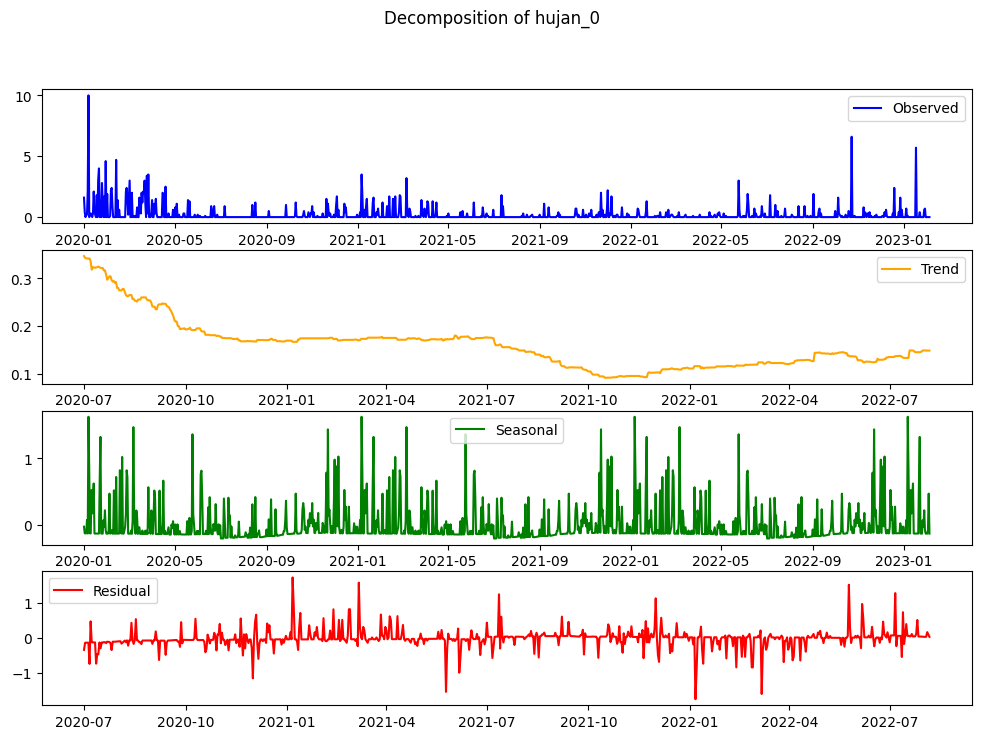

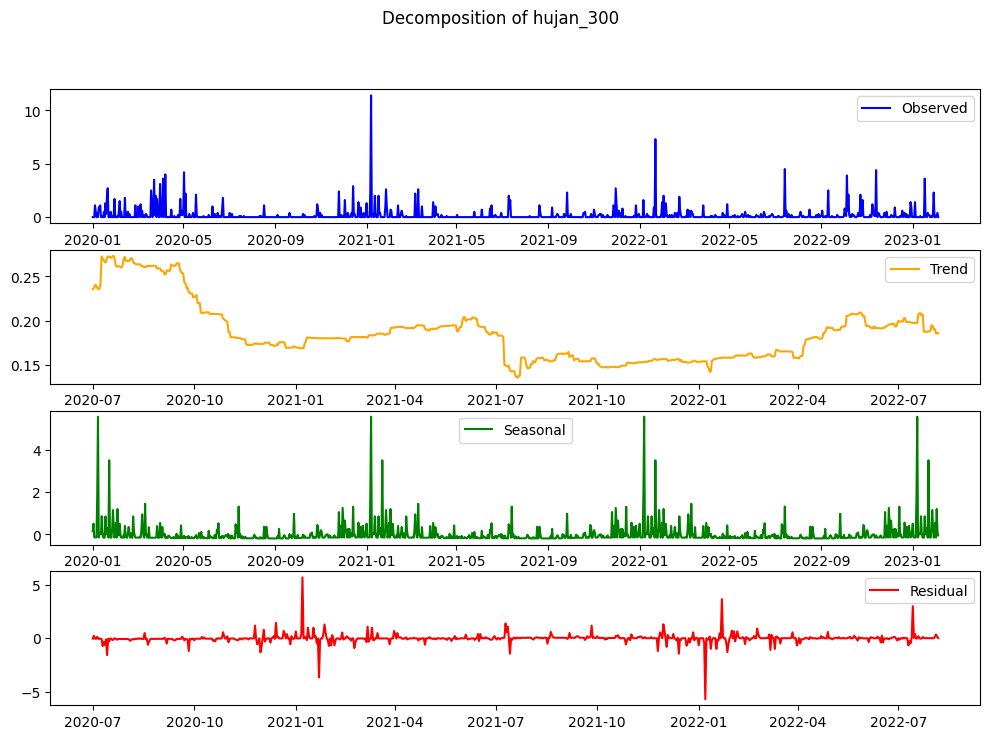

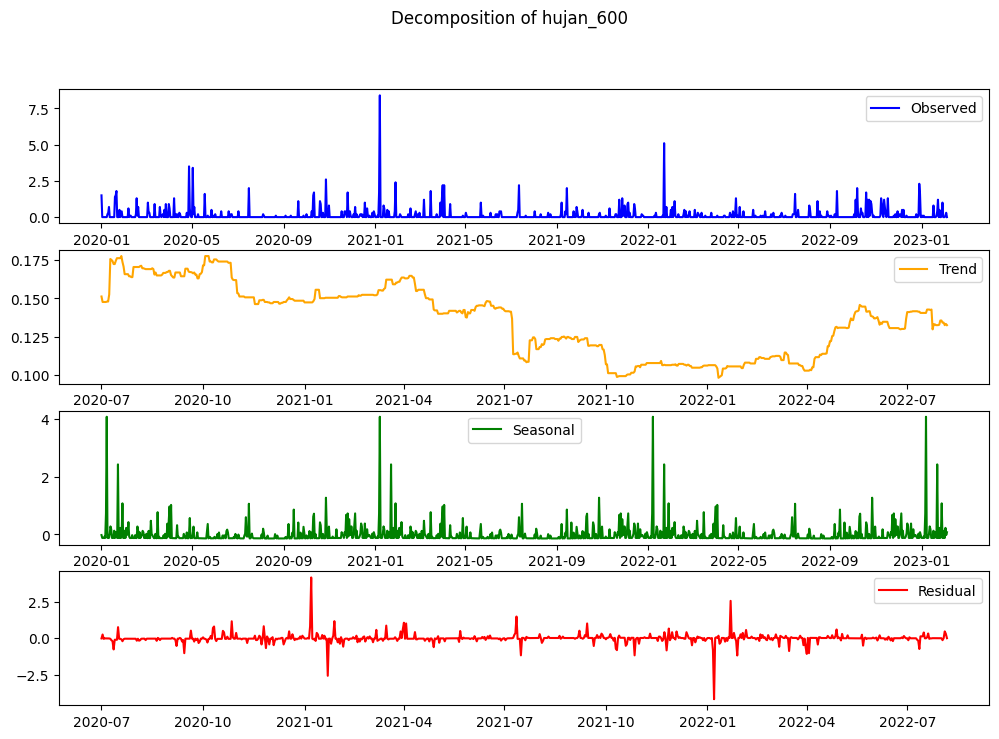

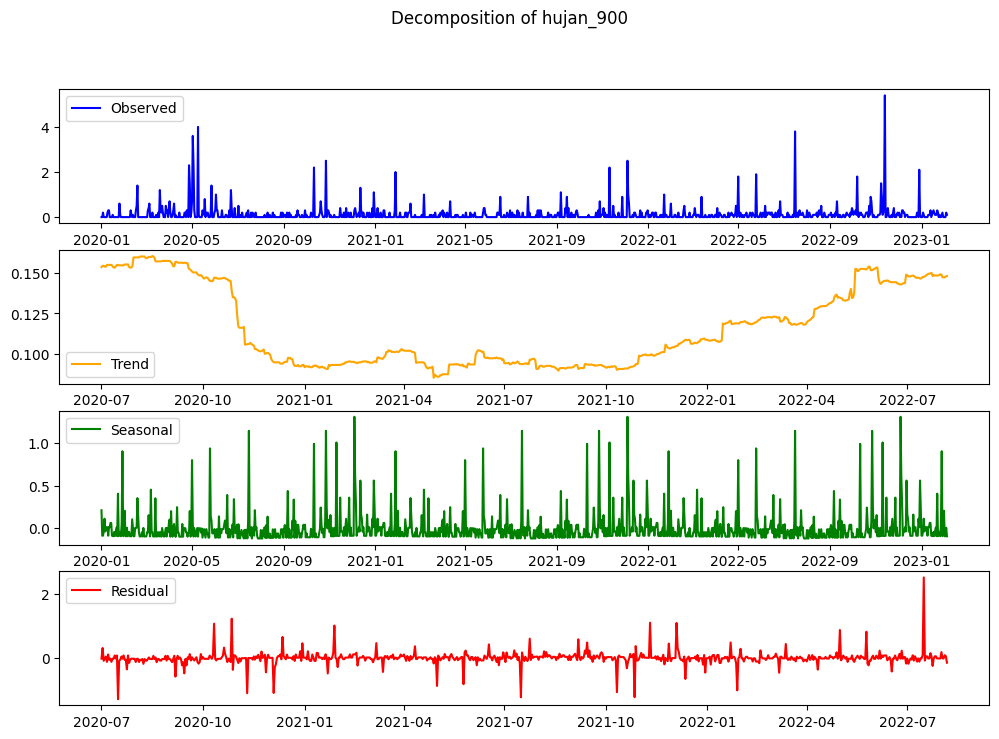

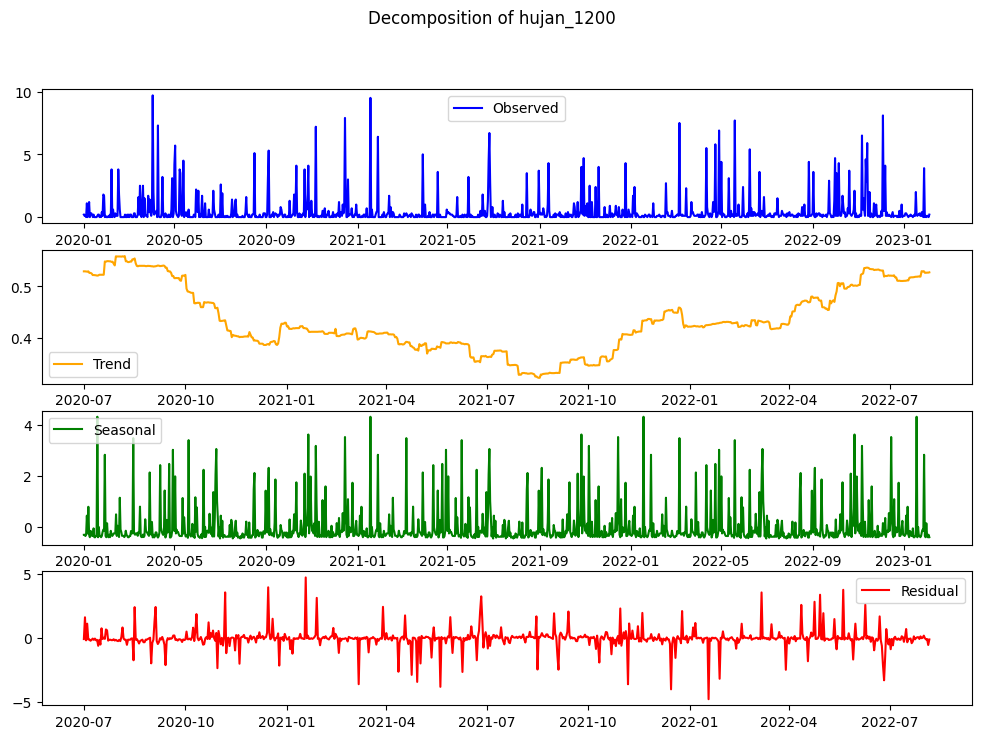

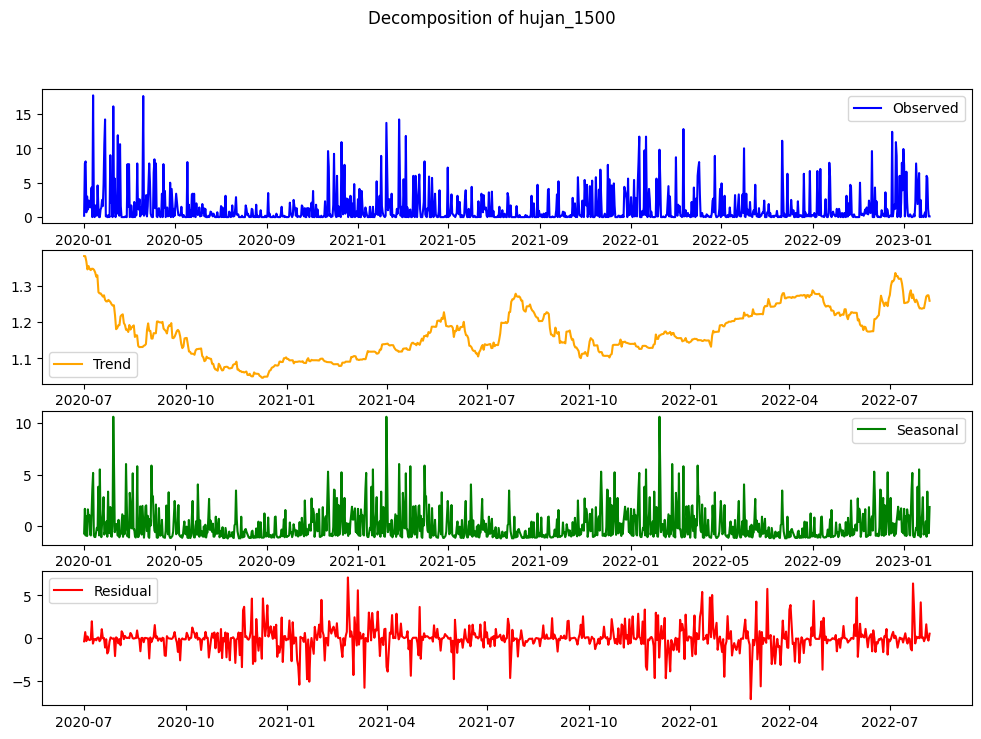

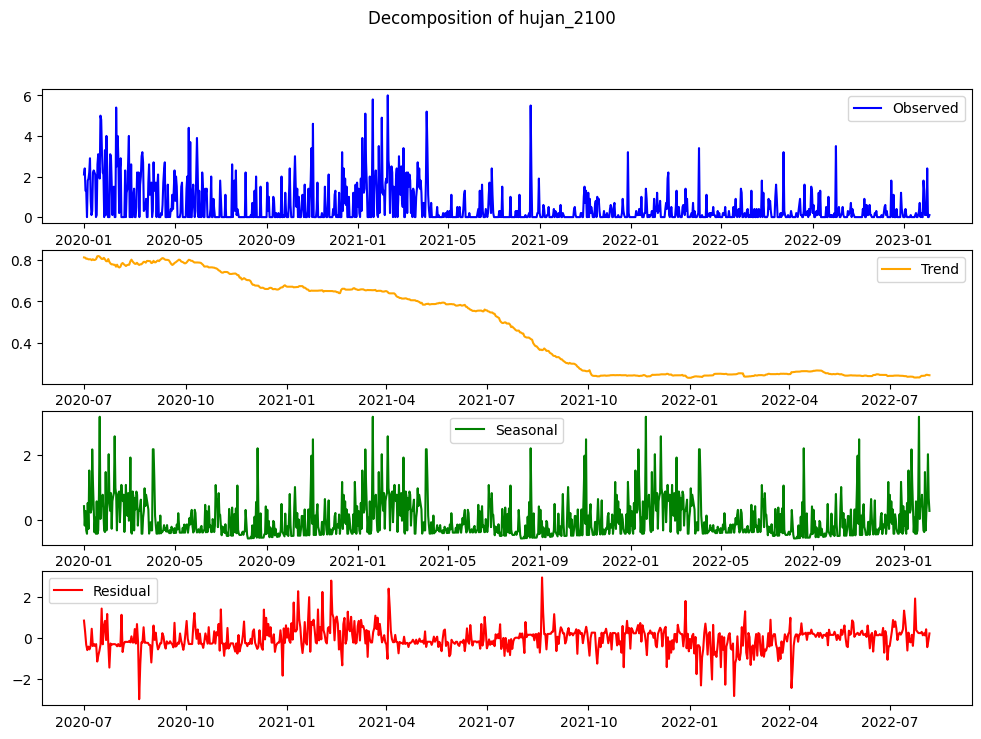

In [ ]:
# Loop melalui setiap kolom target dan lakukan decomposing
for column_name in target_columns:
    # Membaca data hujan dari data pelatihan
    train_column = df[column_name]

    # Melakukan decomposing
    result = seasonal_decompose(train_column, model='additive', period=365)  # Sesuaikan dengan periode musiman yang sesuai

    # Plot hasil decomposing
    plt.figure(figsize=(12, 8))
    plt.subplot(4, 1, 1)
    plt.plot(result.observed, label='Observed', color='blue')
    plt.legend()
    plt.subplot(4, 1, 2)
    plt.plot(result.trend, label='Trend', color='orange')
    plt.legend()
    plt.subplot(4, 1, 3)
    plt.plot(result.seasonal, label='Seasonal', color='green')
    plt.legend()
    plt.subplot(4, 1, 4)
    plt.plot(result.resid, label='Residual', color='red')
    plt.legend()
    plt.suptitle(f'Decomposition of {column_name}')

    plt.show()


### Pengecekan Kestasioneran Data <a class="anchor" id="5.2"></a>

ADF Test for hujan_0:
ADF Statistic: -4.218001471671585
p-value: 0.0006141635017476102
Critical Values:
1%: -3.436270983129607
5%: -2.8641544150183553
10%: -2.5681619941180744


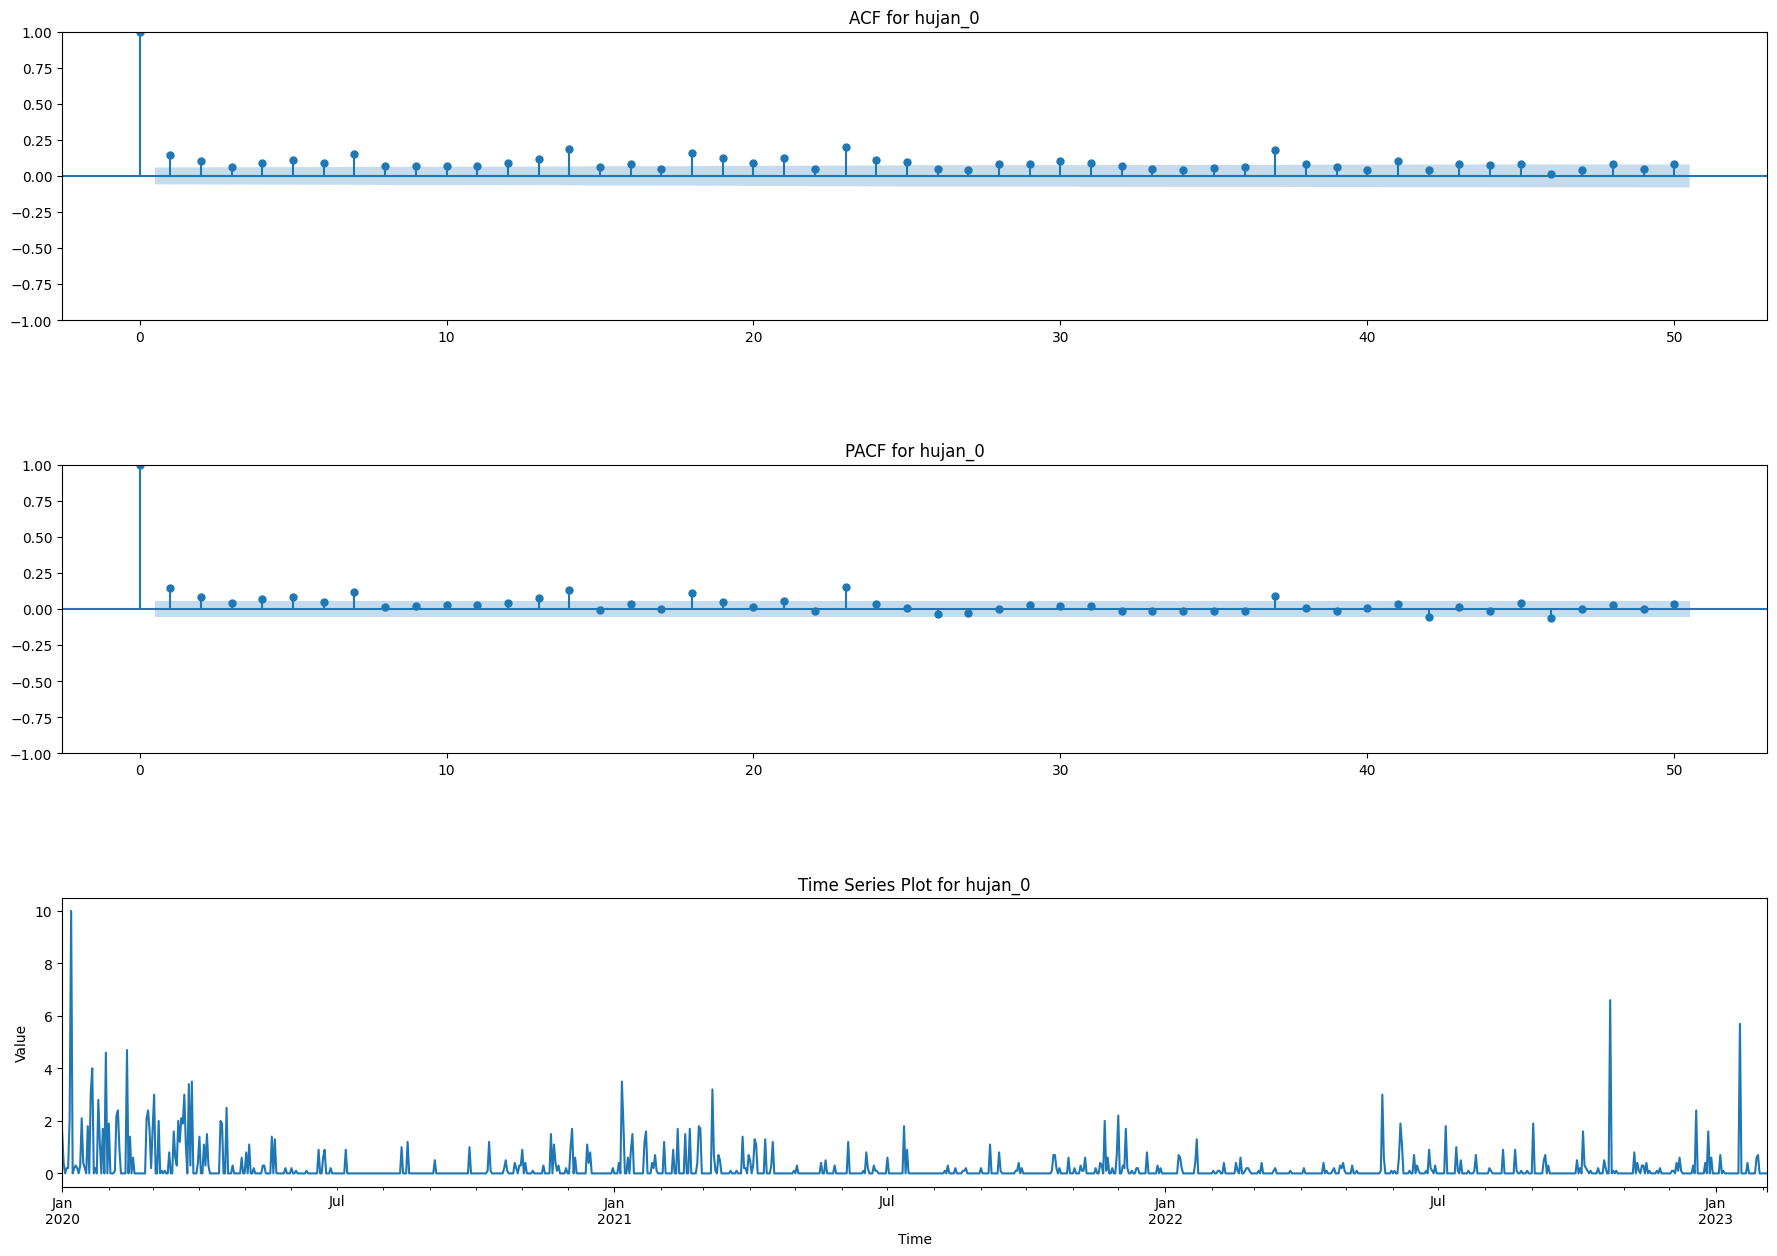

ADF Test for hujan_300:
ADF Statistic: -12.868447961768759
p-value: 4.937535983020897e-24
Critical Values:
1%: -3.4361708439503587
5%: -2.86411024137968
10%: -2.5681384677365924


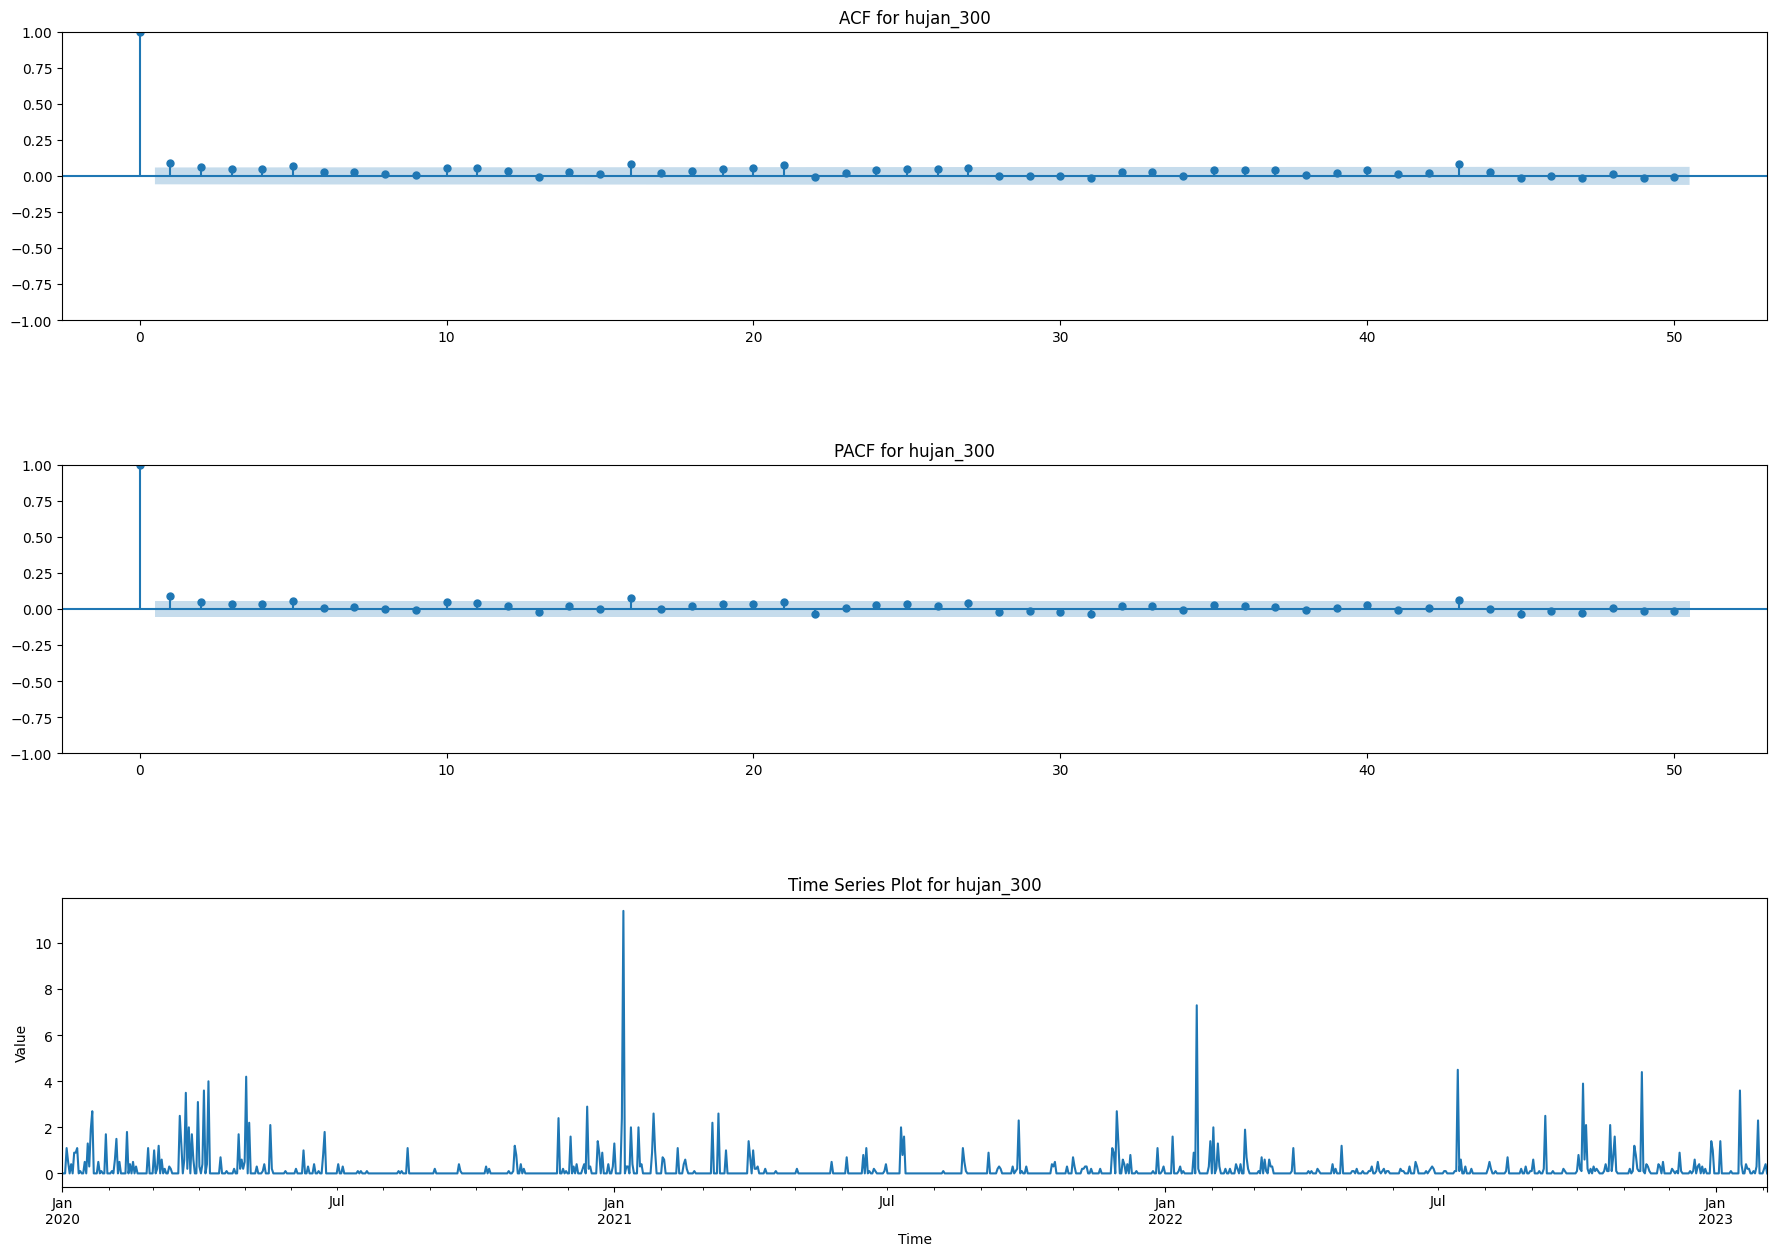

ADF Test for hujan_600:
ADF Statistic: -30.186614363074938
p-value: 0.0
Critical Values:
1%: -3.436150192101723
5%: -2.8641011312034057
10%: -2.5681336157882373


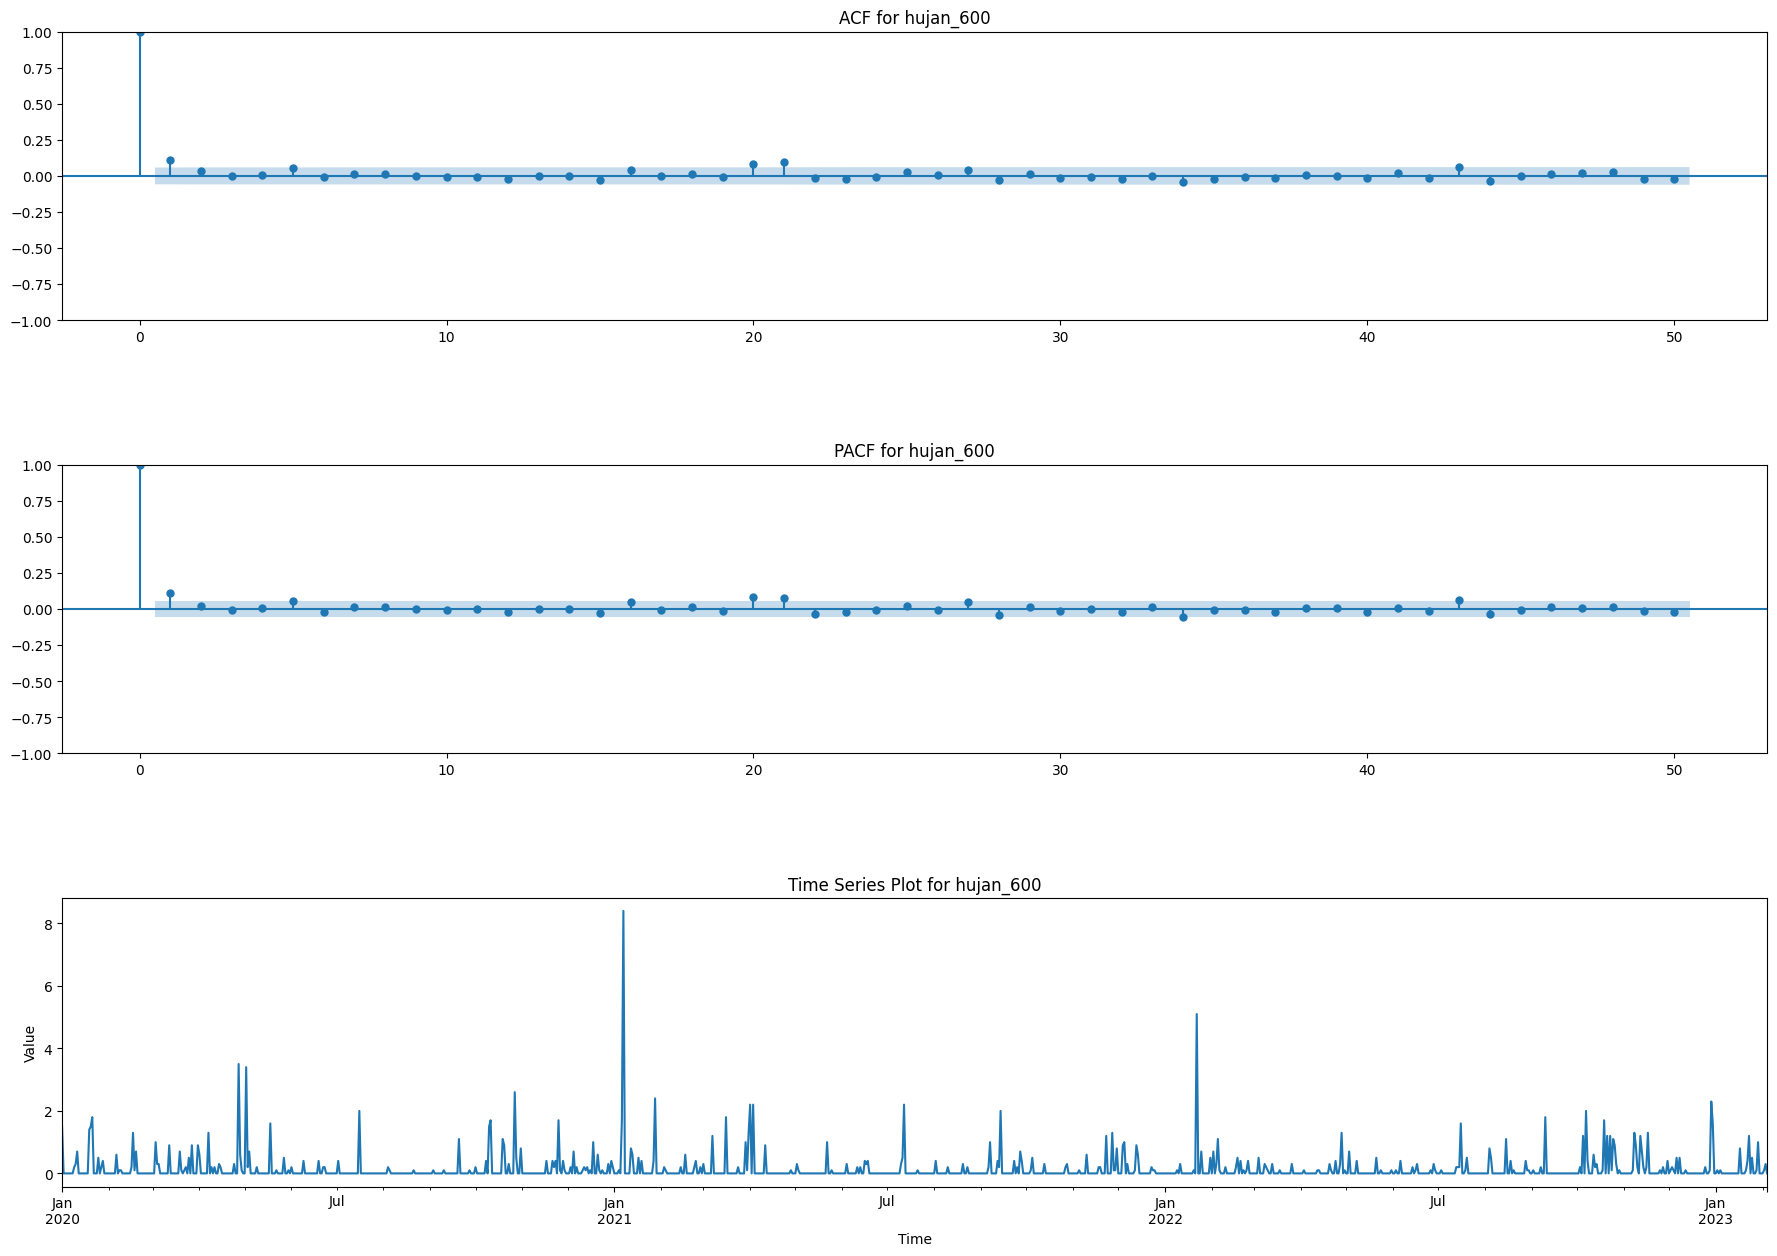

ADF Test for hujan_900:
ADF Statistic: -9.972350812060013
p-value: 2.2231941694560454e-17
Critical Values:
1%: -3.4361812251221555
5%: -2.864114820815637
10%: -2.5681409066817795


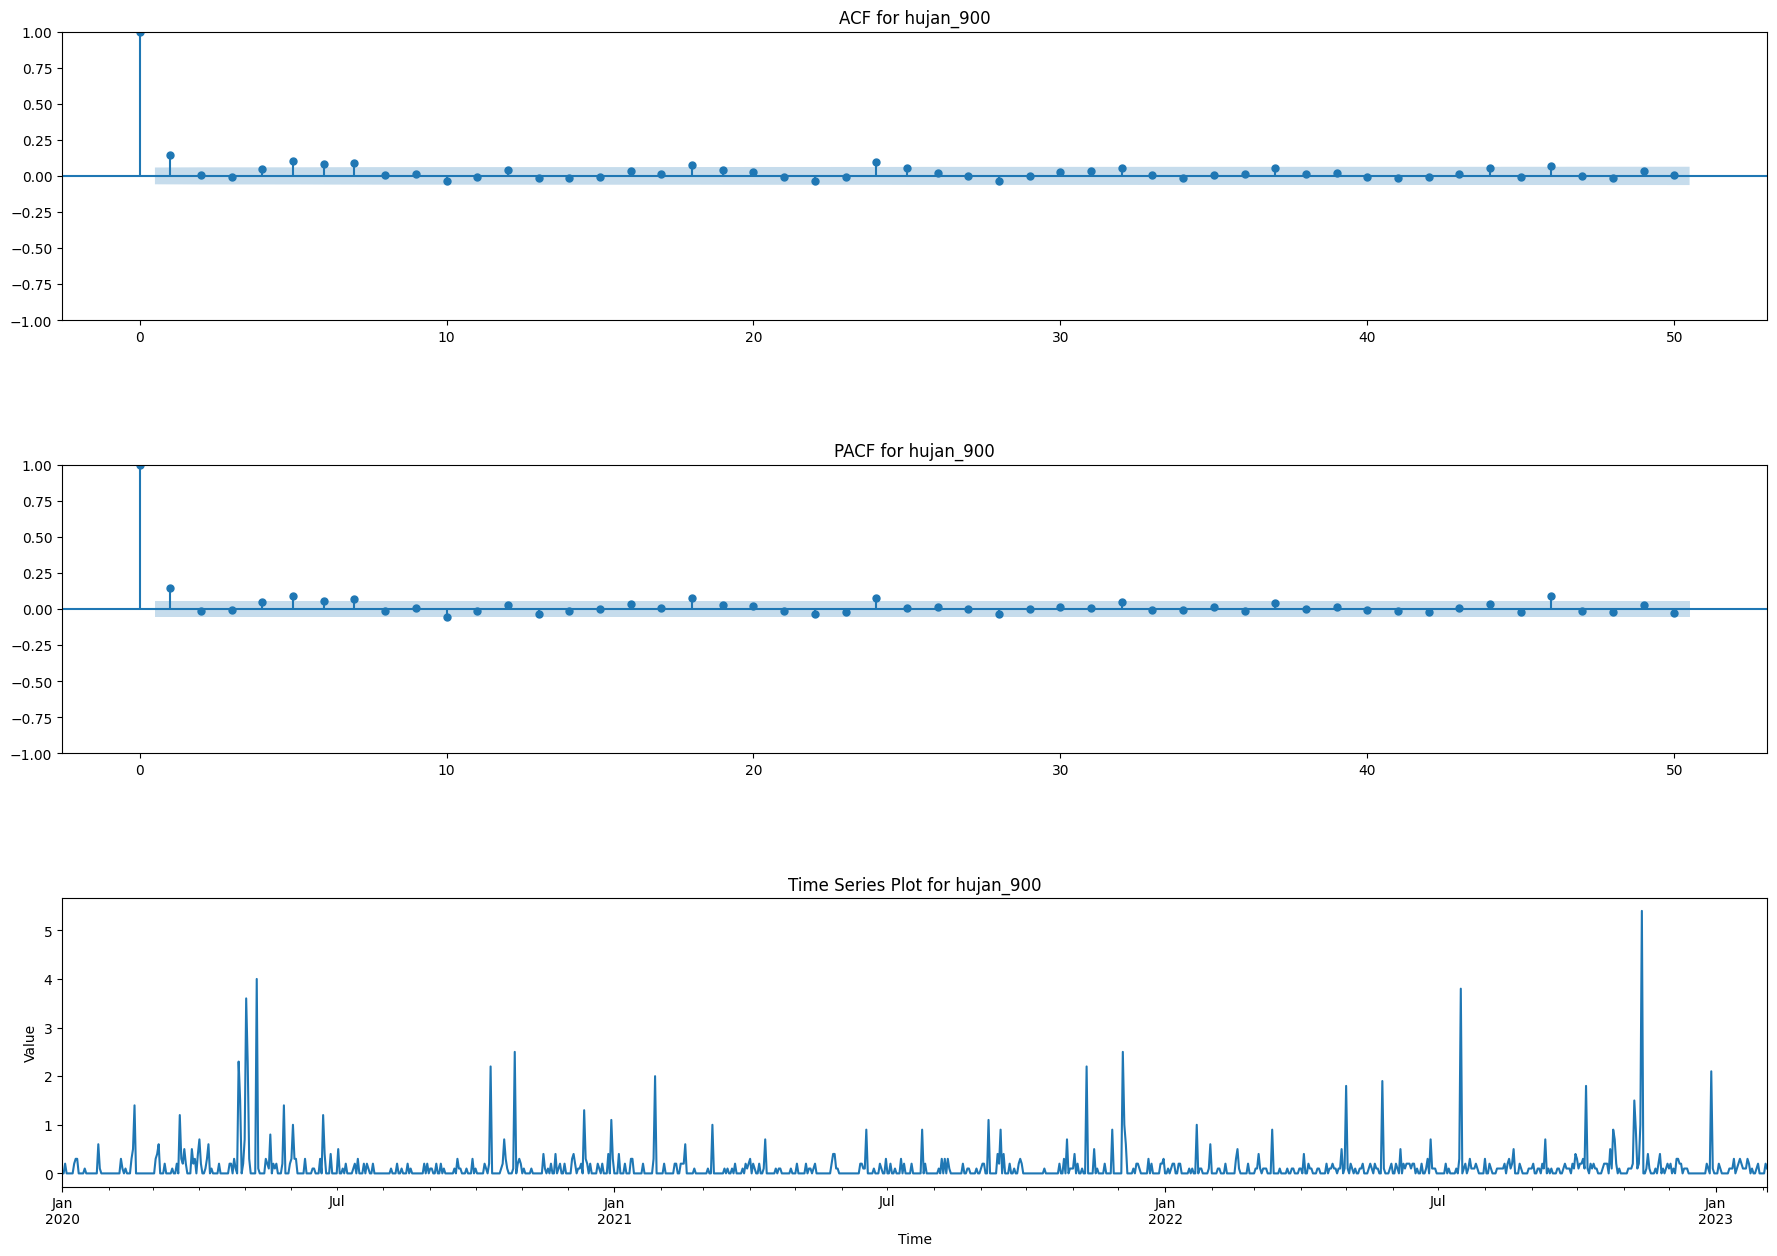

ADF Test for hujan_1200:
ADF Statistic: -31.245023964055402
p-value: 0.0
Critical Values:
1%: -3.436150192101723
5%: -2.8641011312034057
10%: -2.5681336157882373


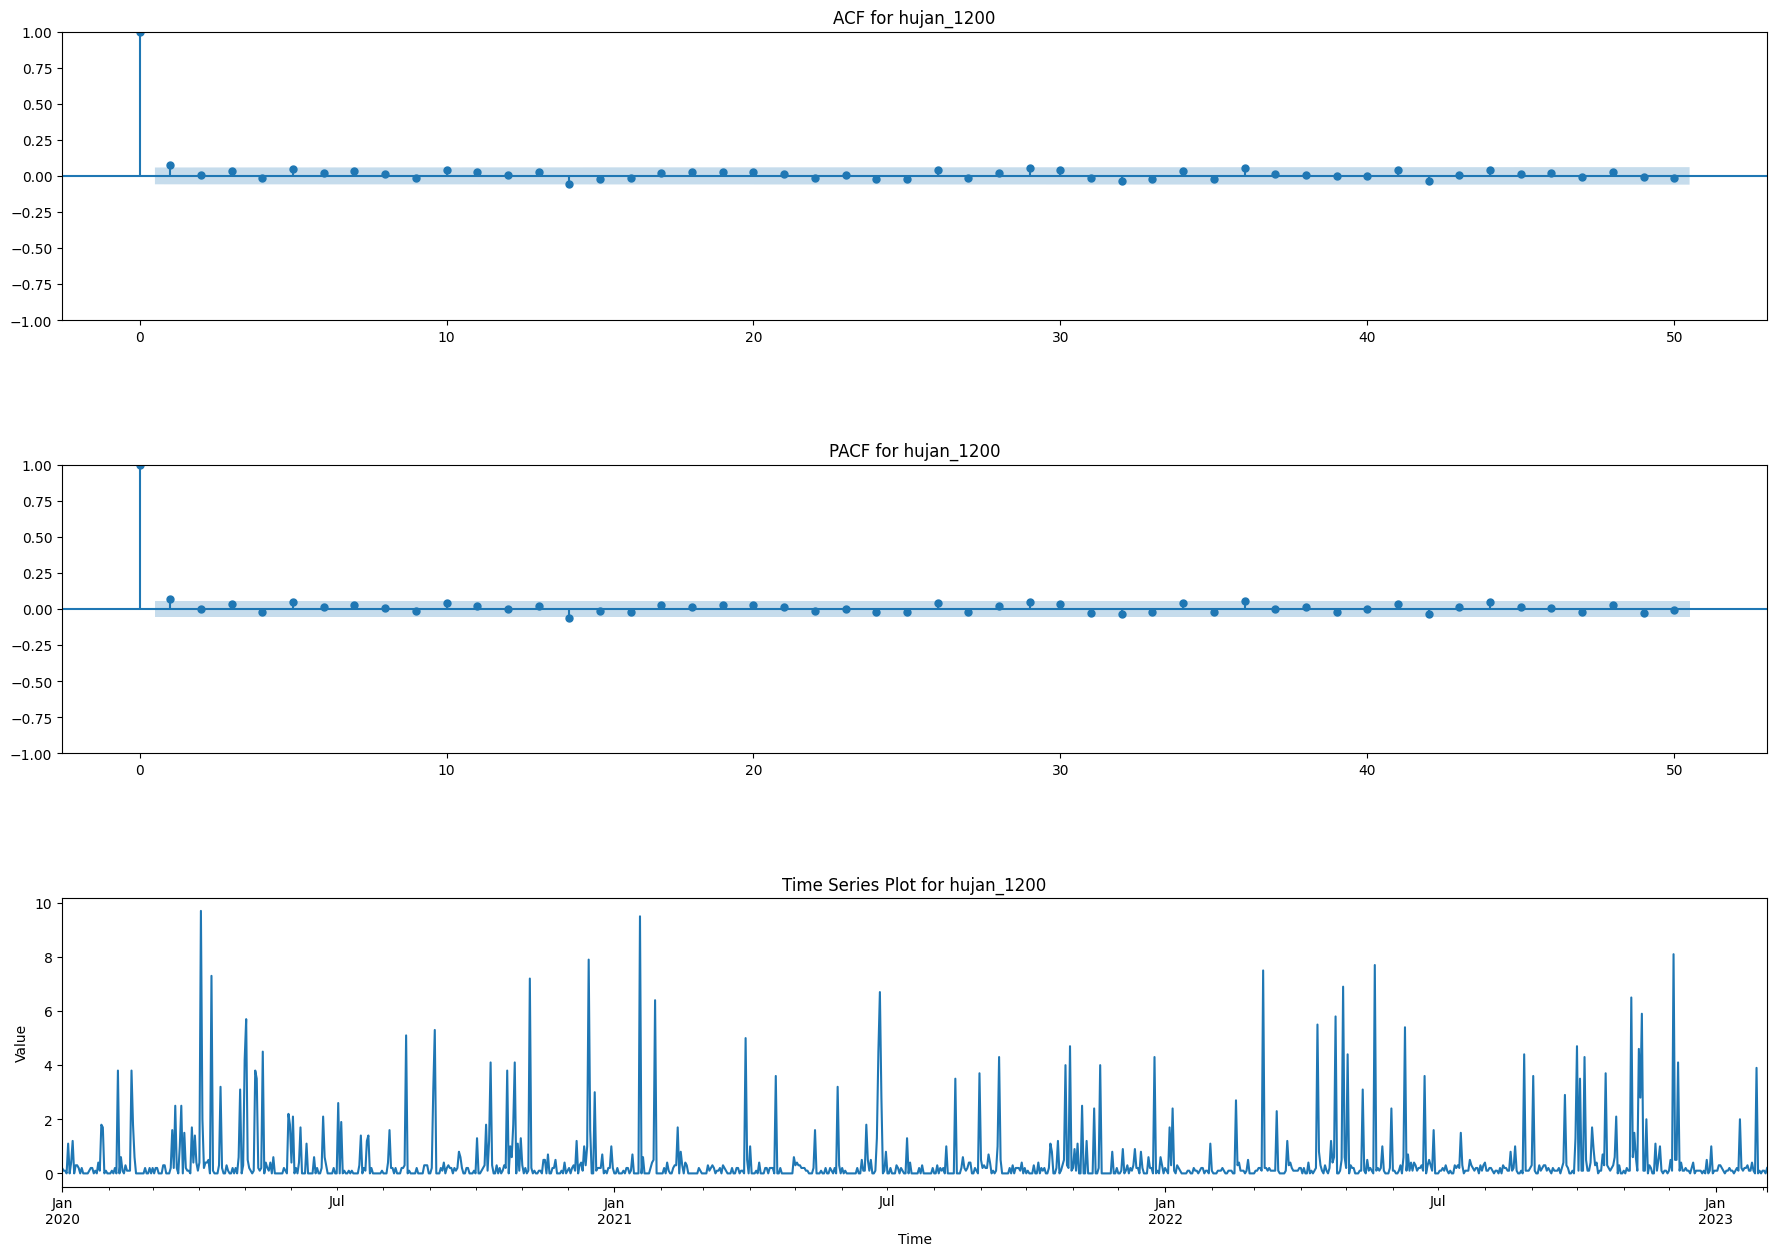

ADF Test for hujan_1500:
ADF Statistic: -6.4517958298518305
p-value: 1.517068456872753e-08
Critical Values:
1%: -3.4362178526562324
5%: -2.86413097815723
10%: -2.5681495118815665


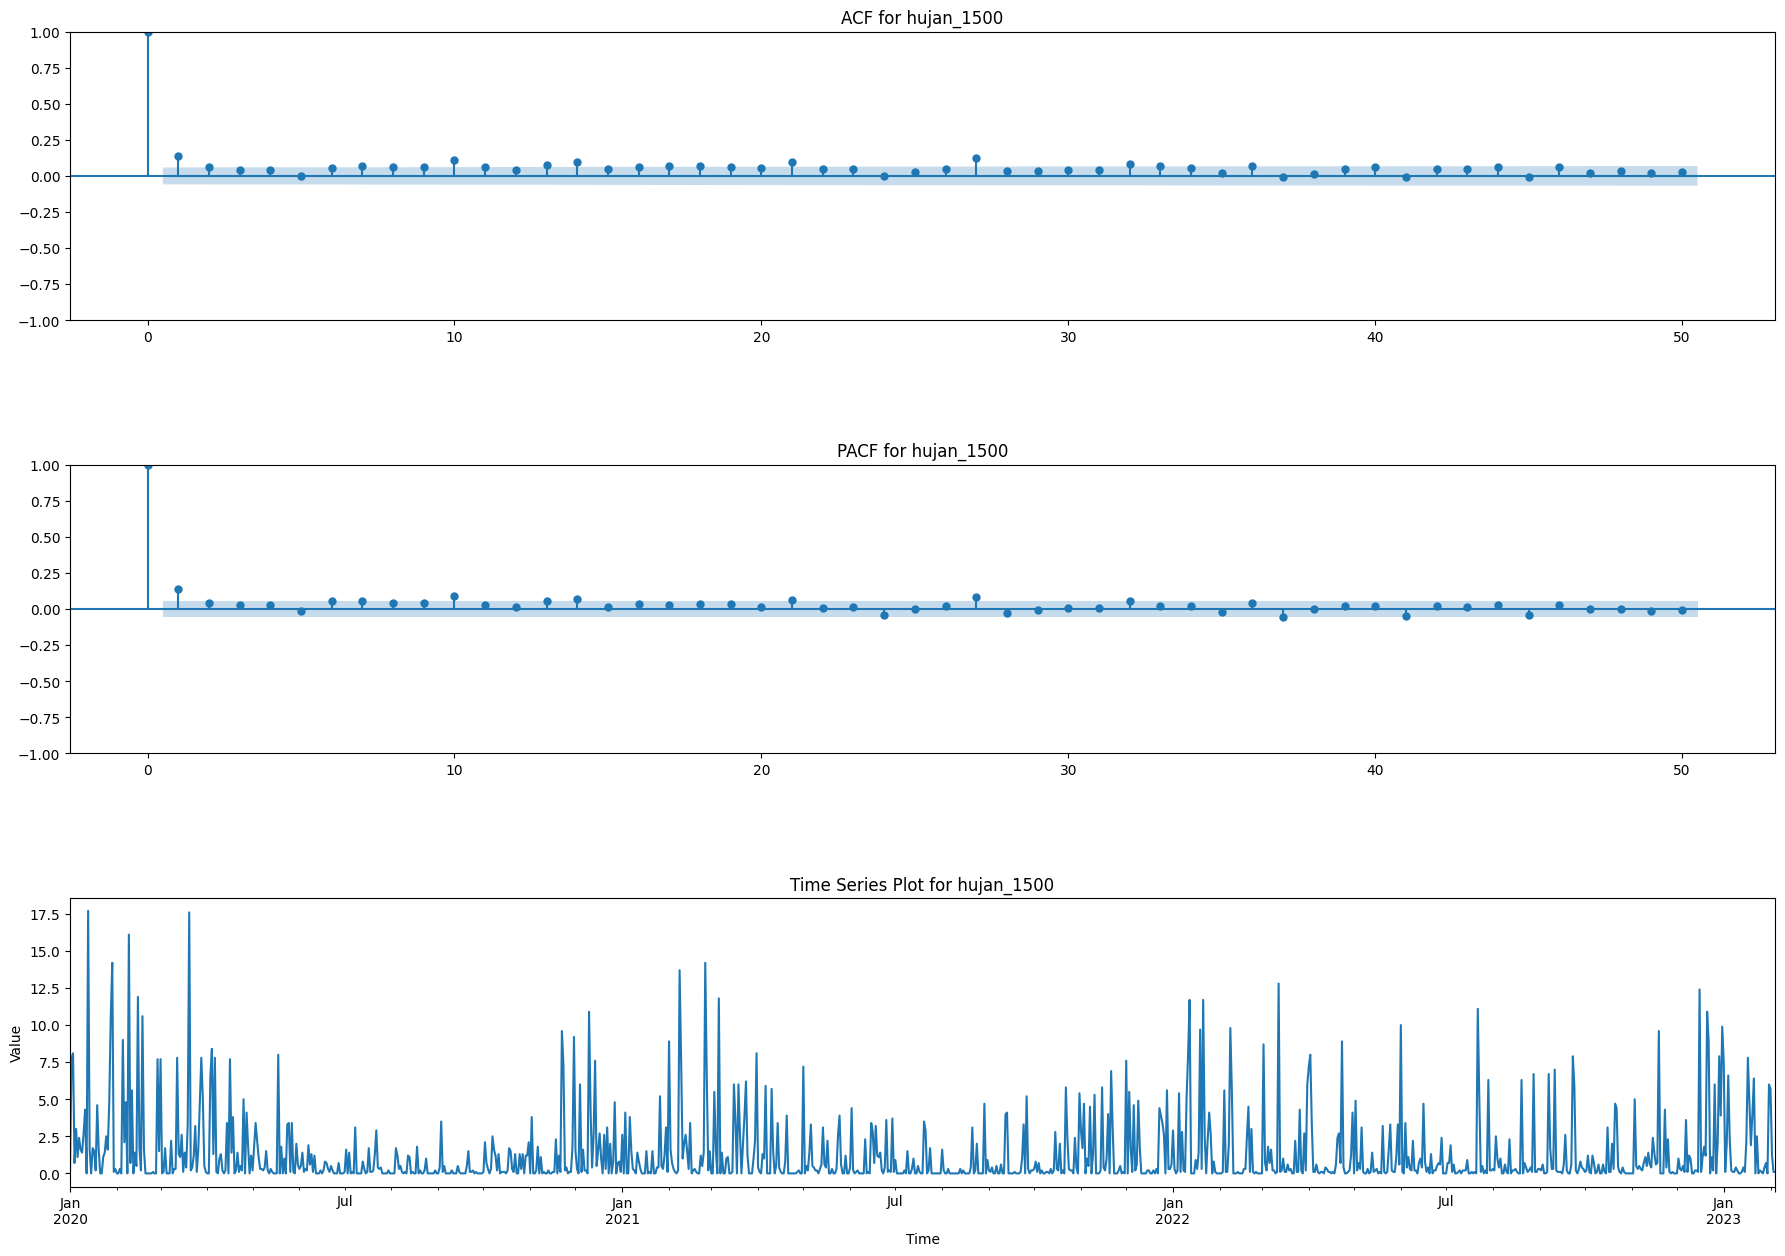

ADF Test for hujan_2100:
ADF Statistic: -3.4465625098425816
p-value: 0.00947034167320234
Critical Values:
1%: -3.436265626824956
5%: -2.864152052269338
10%: -2.568160735738769


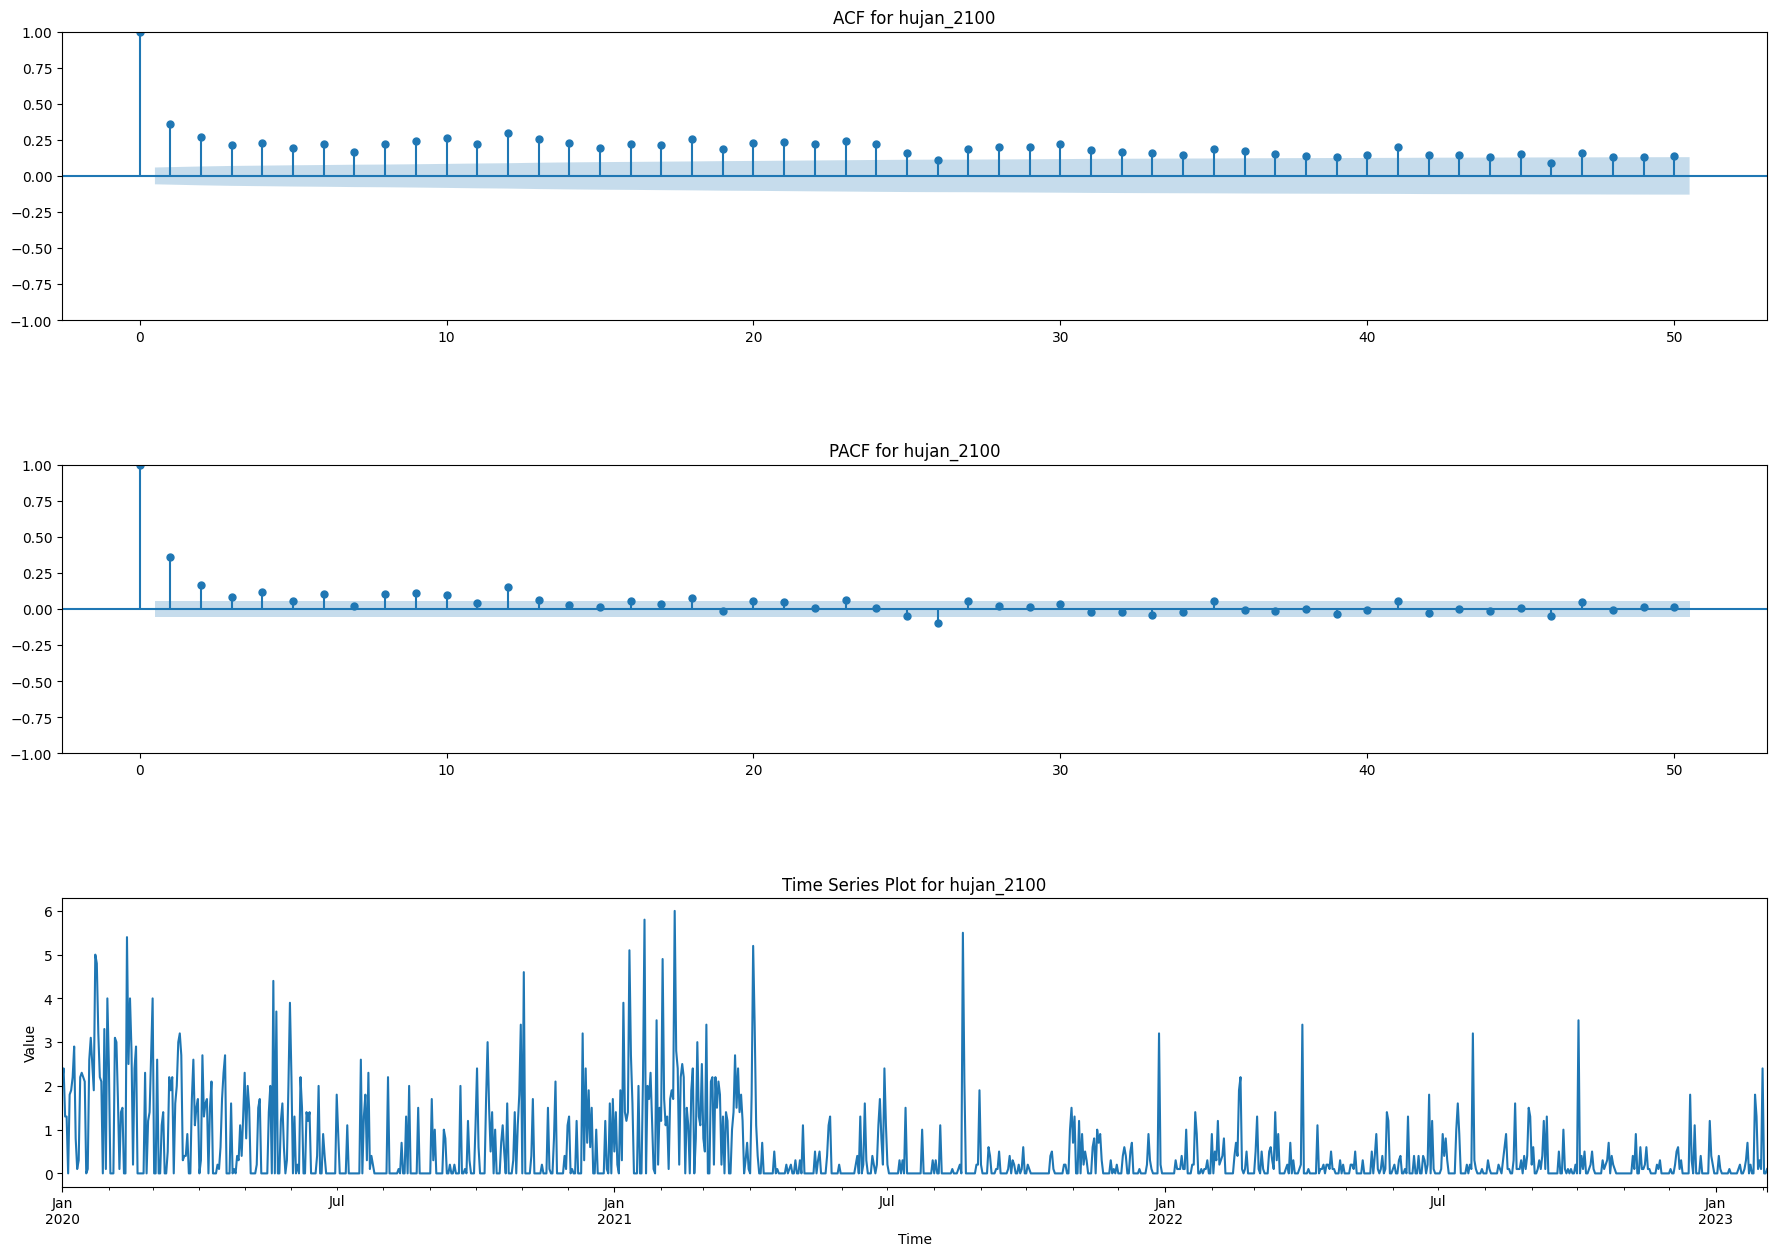

In [ ]:
# Mengecek Kestasioneran Data

# Loop through each target column
for column in target_columns:
    # Check for stationarity using Augmented Dickey-Fuller test
    result = adfuller(df[column], autolag='AIC')
    print(f'ADF Test for {column}:')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'Critical Values:')
    for key, value in result[4].items():
        print(f'{key}: {value}')

    # Create subplots with space between them
    fig, axes = plt.subplots(3, 1, figsize=(22, 15))
    plt.subplots_adjust(hspace=0.5)  # Adjust the vertical space between subplots

    # Plot ACF and PACF to identify seasonality
    plot_acf(df[column], lags=50, ax=axes[0])
    plot_pacf(df[column], lags=50, ax=axes[1])
    axes[0].set_title(f'ACF for {column}')
    axes[1].set_title(f'PACF for {column}')

    # Visualize the time series to identify trends
    df[column].plot(ax=axes[2])
    axes[2].set_title(f'Time Series Plot for {column}')
    axes[2].set_xlabel('Time')
    axes[2].set_ylabel('Value')

    plt.show()

### Analisis Tren dan Musiman <a class="anchor" id="5.3"></a>

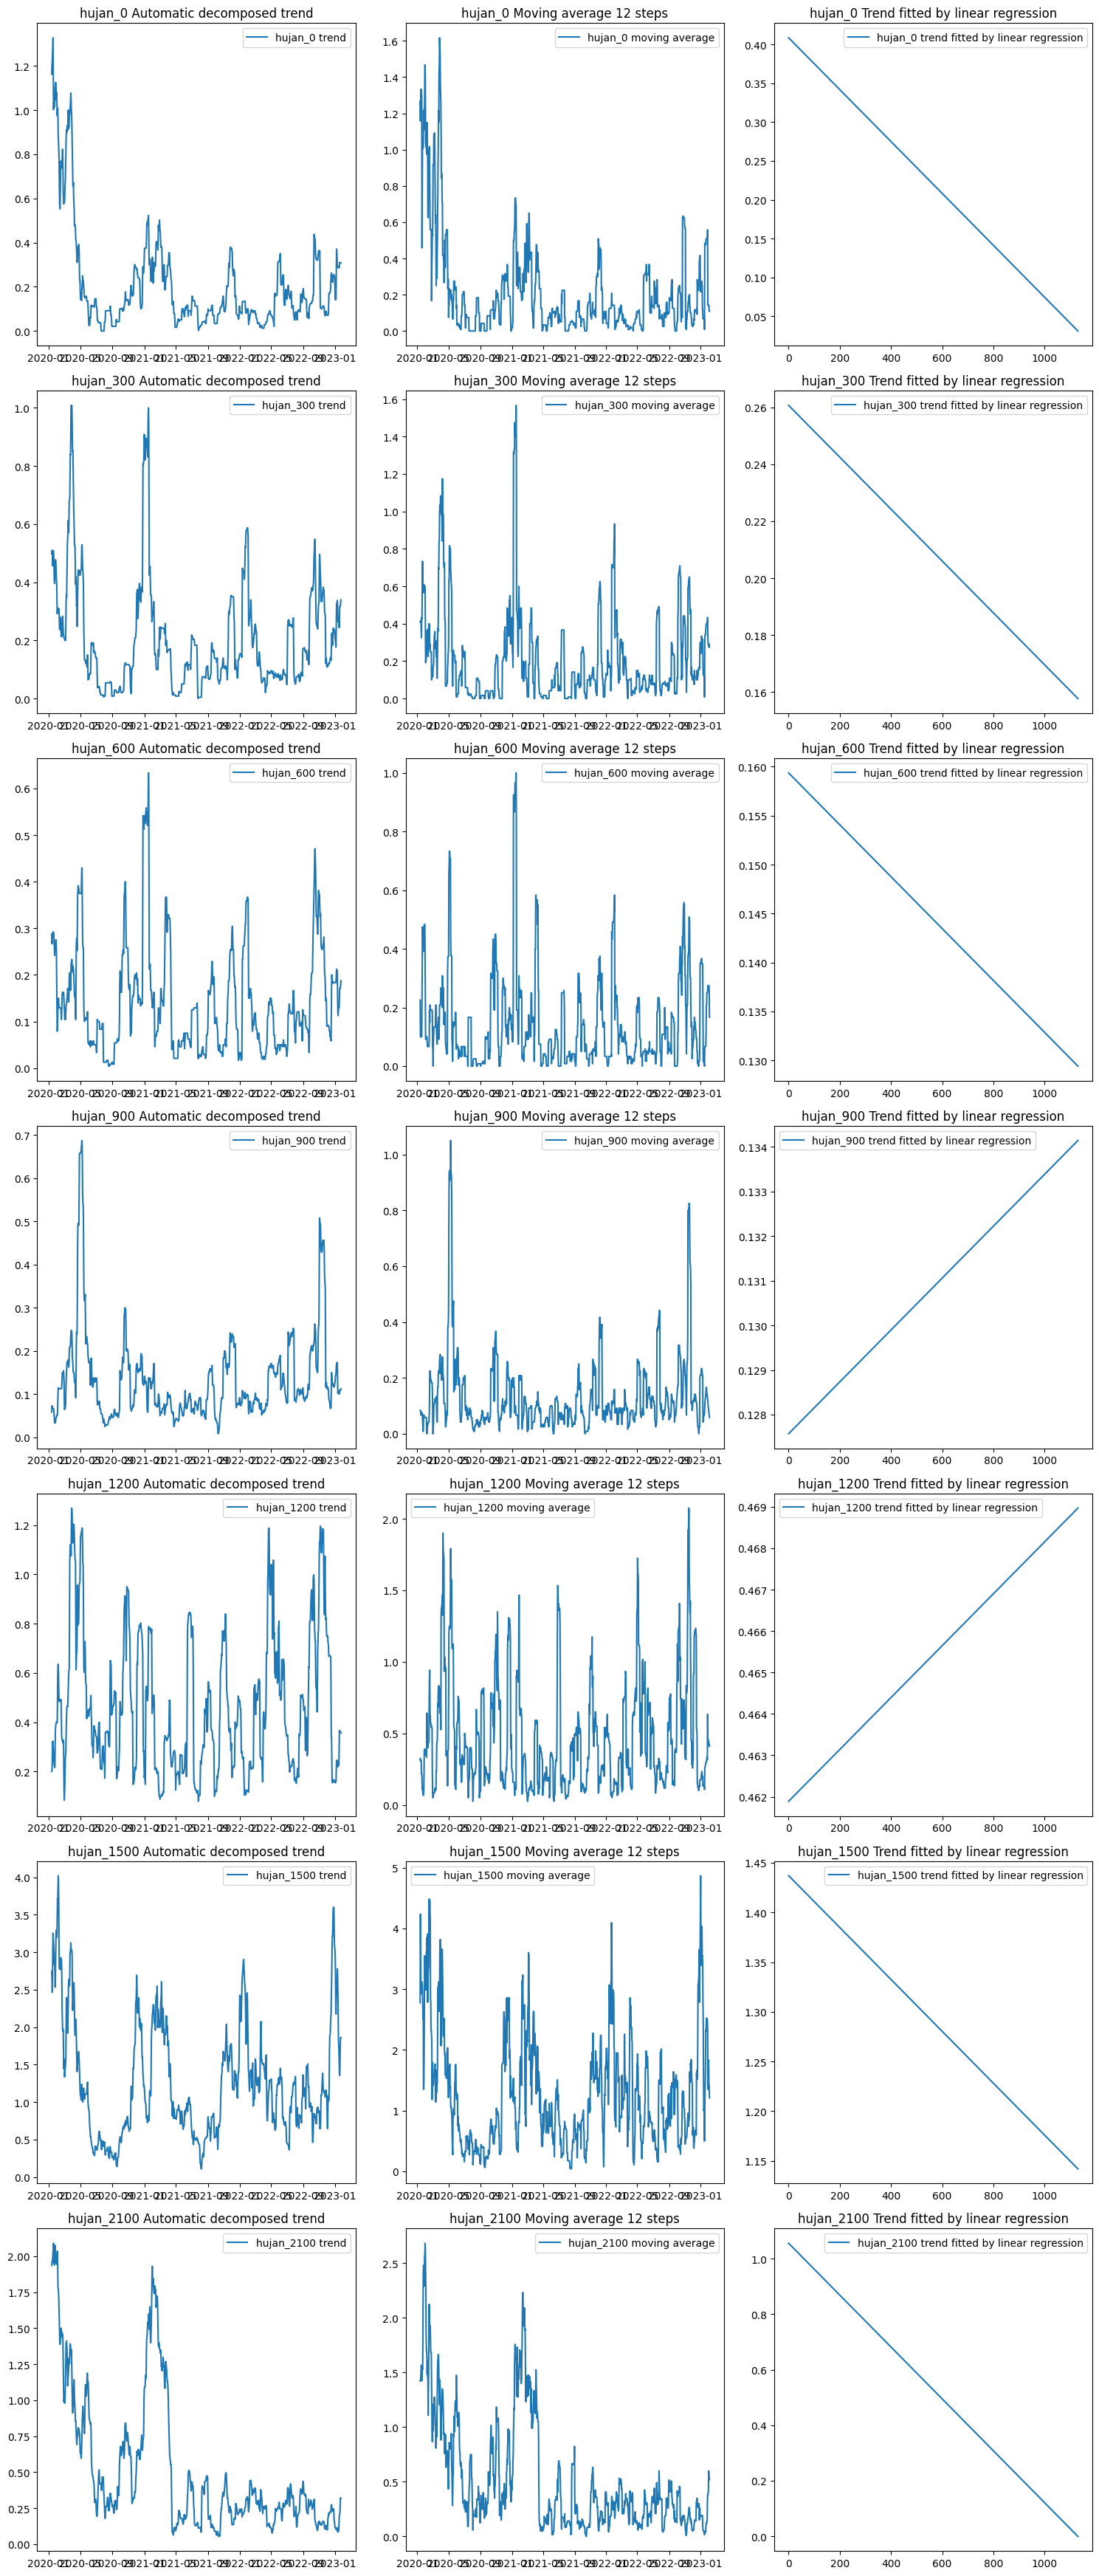

In [ ]:
# Pilih kolom hujan yang akan diprediksi
target_columns = ['hujan_0', 'hujan_300', 'hujan_600', 'hujan_900', 'hujan_1200', 'hujan_1500', 'hujan_2100']

# Set up subplots
fig, axes = plt.subplots(len(target_columns), 3, figsize=(15, len(target_columns) * 5))

for i, column_name in enumerate(target_columns):
    # Ambil kolom hujan dari DataFrame
    series = df[column_name]

    # Lakukan decomposing
    result = seasonal_decompose(series, model='additive', period=24)

    # Plot hasil decomposing
    axes[i, 0].plot(result.trend, label=f'{column_name} trend')
    axes[i, 0].set_title(f"{column_name} Automatic decomposed trend")
    axes[i, 0].legend()

    # Plot moving average
    mm = series.rolling(12).mean()
    axes[i, 1].plot(mm, label=f'{column_name} moving average')
    axes[i, 1].set_title(f"{column_name} Moving average 12 steps")
    axes[i, 1].legend()

    # Plot trend fitted by linear regression
    X = np.reshape(np.arange(len(series)), (len(series), 1))
    y = series.values
    model = LinearRegression()
    model.fit(X, y)

    # Calculate trend
    trend = model.predict(X)
    axes[i, 2].plot(trend, label=f'{column_name} trend fitted by linear regression')
    axes[i, 2].set_title(f"{column_name} Trend fitted by linear regression")
    axes[i, 2].legend()

plt.tight_layout()
plt.show()


## 6. Modelling <a class="anchor" id="6"></a>

In [ ]:
# Tentukan persentase data yang akan digunakan untuk data pelatihan (misalnya, 80%)
train_percentage = 0.8

# Hitung indeks yang memisahkan data pelatihan dan data pengujian
split_index = int(len(df) * train_percentage)

# Bagi data menjadi data pelatihan dan data pengujian
train_data = df[:split_index]
test_data = df[split_index:]

print("Jumlah data train:" , len(train_data))
print("Jumlah data test:" , len(test_data))

Jumlah data train: 904
Jumlah data test: 227


### Exponential Smoothing <a class="anchor" id="6.1"></a>

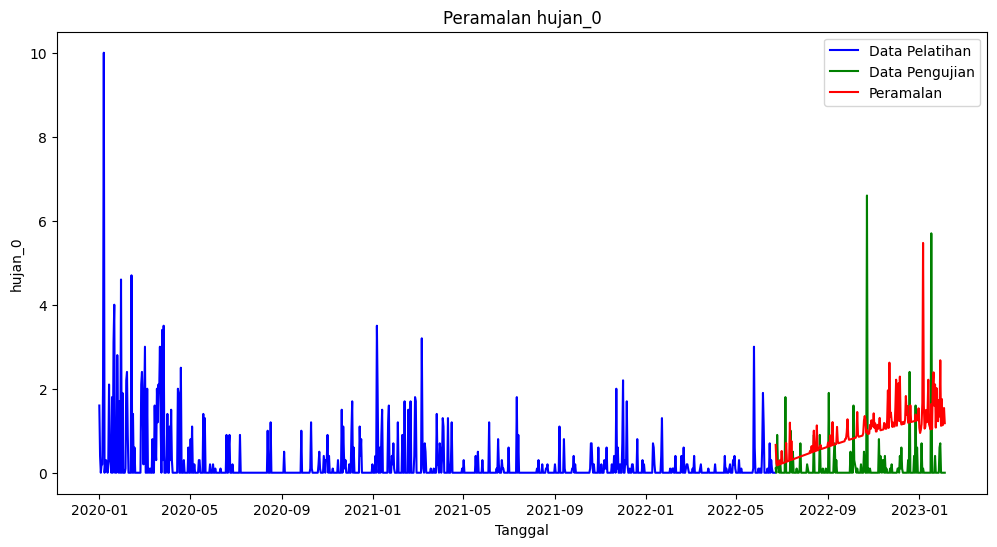

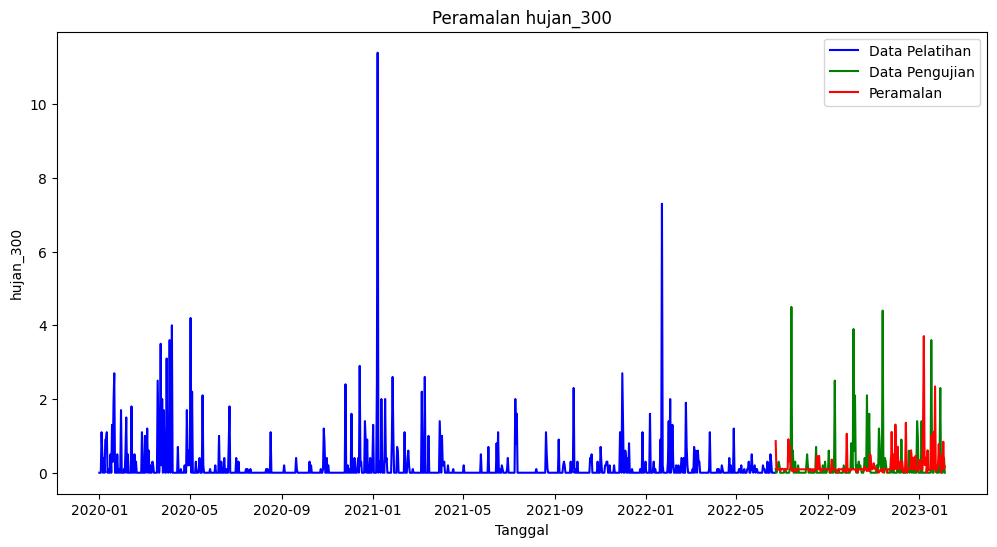

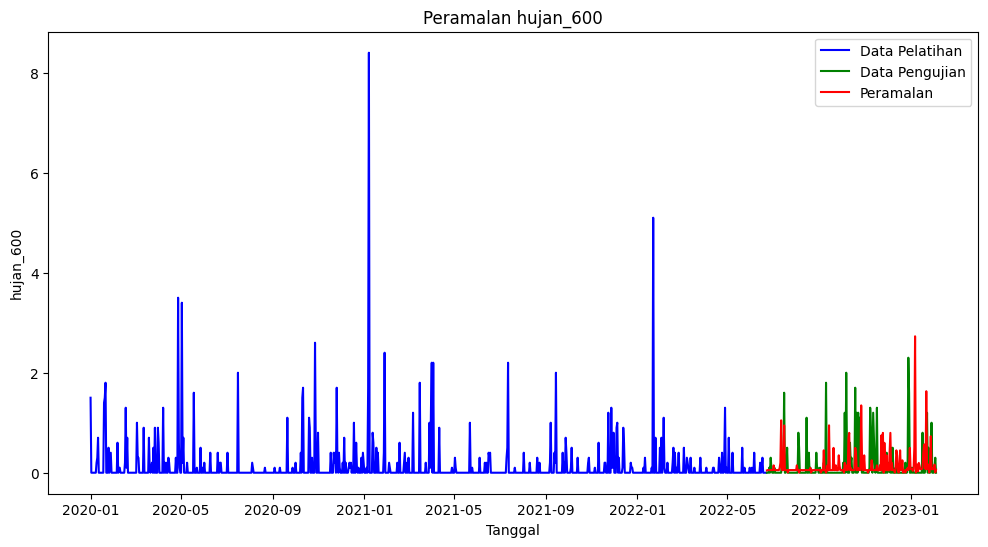

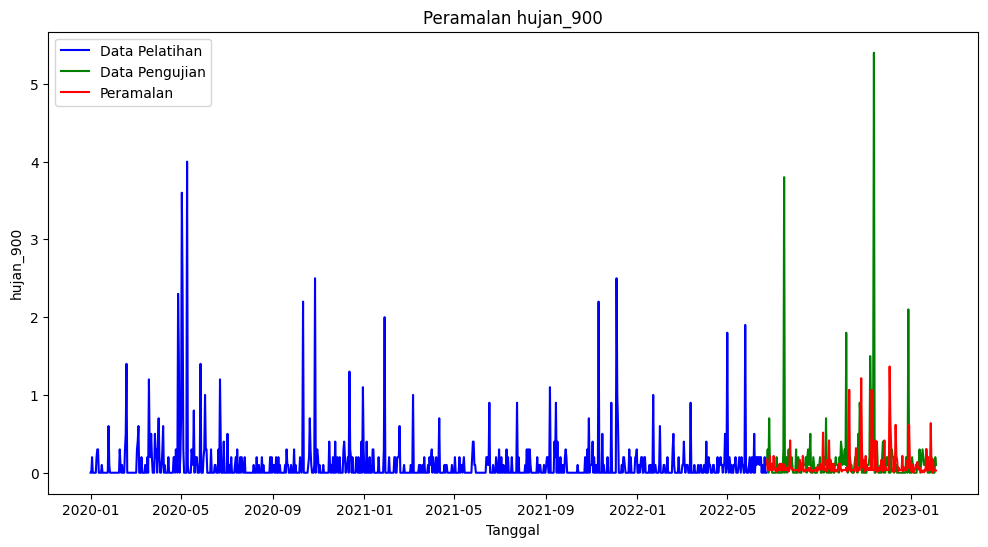

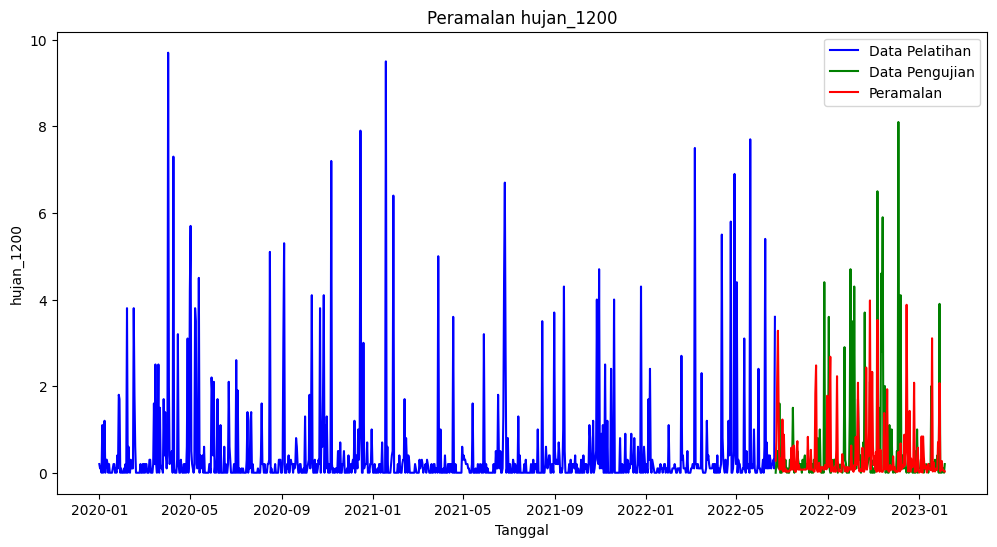

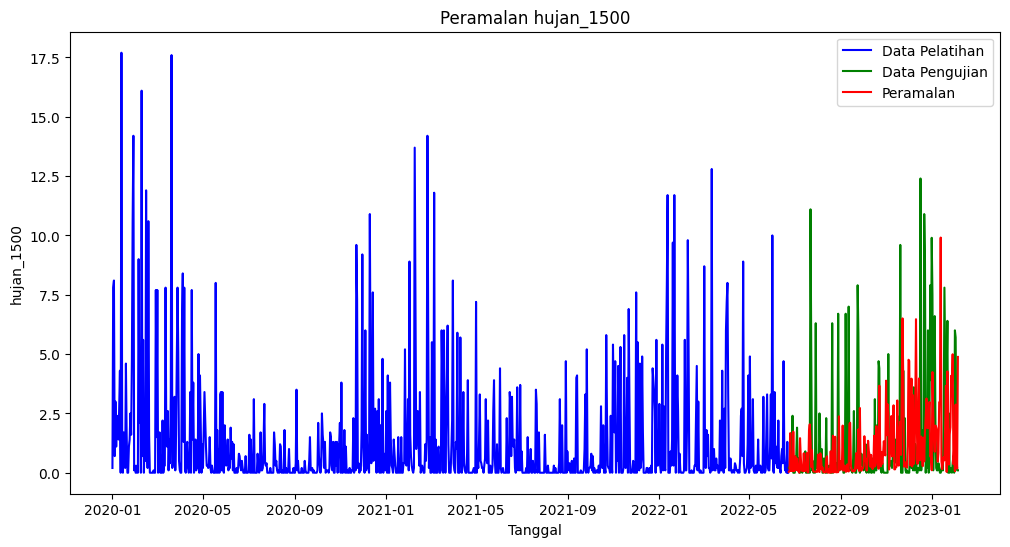

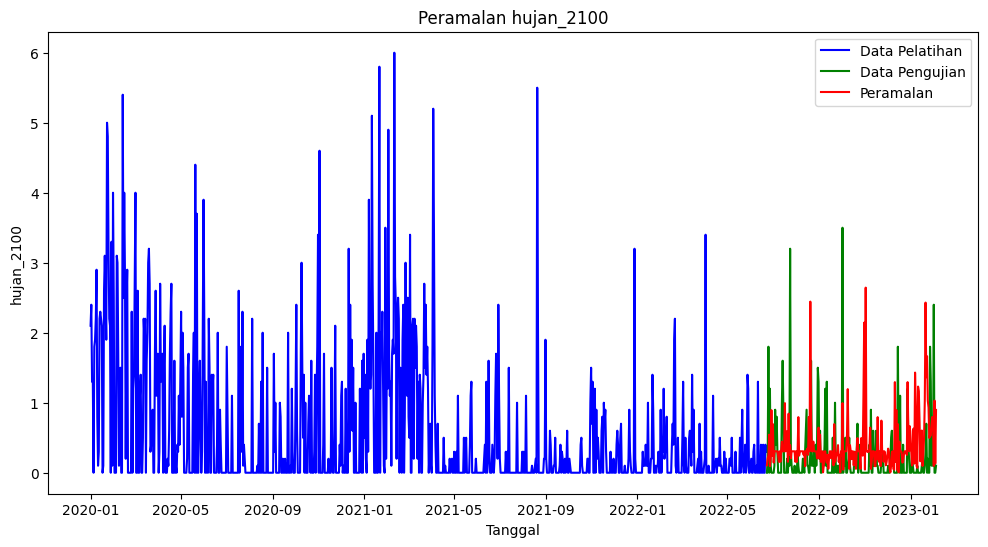

Model: hujan_0, RMSE: 1.1599756093958493, MAE: 0.943551827957549
Model: hujan_300, RMSE: 0.7413660269544324, MAE: 0.33829337371528245
Model: hujan_600, RMSE: 0.4784673961456537, MAE: 0.25224162915775367
Model: hujan_900, RMSE: 0.5375419675168472, MAE: 0.20652473580345712
Model: hujan_1200, RMSE: 1.26999279431073, MAE: 0.6273700864505144
Model: hujan_1500, RMSE: 2.738106863694104, MAE: 1.6517205794815994
Model: hujan_2100, RMSE: 0.6421829957267302, MAE: 0.4293358719090209


In [ ]:
def model_exponential(train_data, test_data, column_name, seasonal_periods=365, train_percentage=0.8):
    # Tentukan persentase data yang akan digunakan untuk data pelatihan
    train_percentage = 0.8

    # Hitung indeks yang memisahkan data pelatihan dan data pengujian
    split_index = int(len(train_data) * train_percentage)

    # Membaca data hujan dari data pelatihan
    train_column = train_data[column_name]

    # Membuat model Eksponensial Smoothing
    model = ExponentialSmoothing(train_column, trend='add', seasonal='add', seasonal_periods=seasonal_periods)

    # Menyesuaikan model dengan data pelatihan
    model_fit = model.fit()

    # Melakukan peramalan
    forecast_test = abs(model_fit.forecast(steps=len(test_data)))

    # Evaluasi hasil peramalan
    rmse = np.sqrt(mean_squared_error(test_data[column_name], forecast_test))
    mae = mean_absolute_error(test_data[column_name], forecast_test)

    # Menyimpan hasil evaluasi ke dalam dictionary
    evaluation_results = {
        'RMSE': rmse,
        'MAE': mae,
    }

    # Plot hasil peramalan
    plt.figure(figsize=(12, 6))
    plt.plot(train_data.index, train_column, label='Data Pelatihan', color='blue')
    plt.plot(test_data.index, test_data[column_name], label='Data Pengujian', color='green')
    plt.plot(test_data.index, forecast_test, label='Peramalan', color='red')
    plt.title(f'Peramalan {column_name}')
    plt.xlabel('Tanggal')
    plt.ylabel(column_name)
    plt.legend()
    plt.show()

    return evaluation_results

# Contoh penggunaan fungsi
results_dict = {}

results_dict['hujan_0'] = model_exponential(train_data, test_data, 'hujan_0', seasonal_periods=365)
results_dict['hujan_300'] = model_exponential(train_data, test_data, 'hujan_300', seasonal_periods=365)
results_dict['hujan_600'] = model_exponential(train_data, test_data, 'hujan_600', seasonal_periods=365)
results_dict['hujan_900'] = model_exponential(train_data, test_data, 'hujan_900', seasonal_periods=365)
results_dict['hujan_1200'] = model_exponential(train_data, test_data, 'hujan_1200', seasonal_periods=365)
results_dict['hujan_1500'] = model_exponential(train_data, test_data, 'hujan_1500', seasonal_periods=365)
results_dict['hujan_2100'] = model_exponential(train_data, test_data, 'hujan_2100', seasonal_periods=365)

# Print hasil evaluasi
for key, value in results_dict.items():
    print(f'Model: {key}, RMSE: {value["RMSE"]}, MAE: {value["MAE"]}')


## 7. Validasi Model <a class="anchor" id="7"></a>

In [ ]:
# Convert dictionary to DataFrame
results_df = pd.DataFrame(results_dict).T

# Print the DataFrame
results_df

RMSE       MAE
hujan_0     1.159976  0.943552
hujan_300   0.741366  0.338293
hujan_600   0.478467  0.252242
hujan_900   0.537542  0.206525
hujan_1200  1.269993  0.627370
hujan_1500  2.738107  1.651721
hujan_2100  0.642183  0.429336

## 8. Forecast <a class="anchor" id="8"></a>

In [ ]:
# Fungsi untuk membuat dan menyimpan model ke dalam file pickle
def save_model_to_pickle(model, filename):
    with open(filename, 'wb') as file:
        pickle.dump(model, file)

# Kolom yang ingin dievaluasi
columns_to_evaluate = ['hujan_0', 'hujan_300', 'hujan_600', 'hujan_900', 'hujan_1200', 'hujan_1500', 'hujan_2100']

# Inisialisasi folder untuk menyimpan model
model_folder = 'models_train/'

# Membuat folder jika belum ada
os.makedirs(model_folder, exist_ok=True)

# Membuat dan menyimpan model untuk setiap kolom
for col in columns_to_evaluate:
    train_column = train_data[col]
    model = ExponentialSmoothing(train_column, trend='add', seasonal='add', seasonal_periods=365)
    model_fit = model.fit()

    # Menyimpan model ke dalam file pickle
    model_filename = os.path.join(model_folder, col + '_model.pkl')
    save_model_to_pickle(model_fit, model_filename)
    print(f'Model for {col} saved to {model_filename}')

Model for hujan_0 saved to models_train/hujan_0_model.pkl
Model for hujan_300 saved to models_train/hujan_300_model.pkl
Model for hujan_600 saved to models_train/hujan_600_model.pkl
Model for hujan_900 saved to models_train/hujan_900_model.pkl
Model for hujan_1200 saved to models_train/hujan_1200_model.pkl
Model for hujan_1500 saved to models_train/hujan_1500_model.pkl
Model for hujan_2100 saved to models_train/hujan_2100_model.pkl


In [ ]:
model_dir = '/content/models_train'
all_models = {}

for file_name in os.listdir(model_dir):
    if file_name.endswith('.pkl'):
        model_name = file_name.split('.')[0]
        with open(os.path.join(model_dir, file_name), 'rb') as model_file:
            model = pickle.load(model_file)
        all_models[model_name] = model

forecast_results = {}
test_data = test_data

for model_name, model in all_models.items():
    forecast = model.forecast(len(test_data) + 365)  # Gantilah dengan metode pengambilan panjang peramalan yang sesuai
    forecast_results[model_name] = forecast

In [ ]:
forecast_df = pd.DataFrame(forecast_results)
forecast_df = abs(forecast_df).round(2)
forecast_df

hujan_2100_model  hujan_300_model  hujan_1200_model  \
2022-06-23              0.11             0.86              0.28   
2022-06-24              0.21             0.09              0.73   
2022-06-25              0.24             0.09              2.18   
2022-06-26              0.54             0.09              3.28   
2022-06-27              0.09             0.09              1.33   
...                      ...              ...               ...   
2024-01-31              0.33             0.34              0.22   
2024-02-01              0.30             0.12              0.11   
2024-02-02              0.63             0.81              0.11   
2024-02-03              0.27             0.08              0.08   
2024-02-04              0.50             0.14              0.08   

            hujan_600_model  hujan_0_model  hujan_900_model  hujan_1500_model  
2022-06-23             0.05           0.66             0.17              0.03  
2022-06-24             0.05           0.22             0.03              0.07  
2022-06-25             0.05           0.18             0.03              1.67  
2022-06-26             0.05           0.18             0.07              0.08  
2022-06-27             0.05           0.29             0.22              0.33  
...                     ...            ...              ...               ...  
2024-01-31             0.06           3.53             0.17              0.28  
2024-02-01             0.11           2.90             0.03              3.21  
2024-02-02             0.13           2.94             0.03              0.88  
2024-02-03             0.04           3.32             0.03              0.52  
2024-02-04             0.03           2.96             0.03              5.22  

[592 rows x 7 columns]

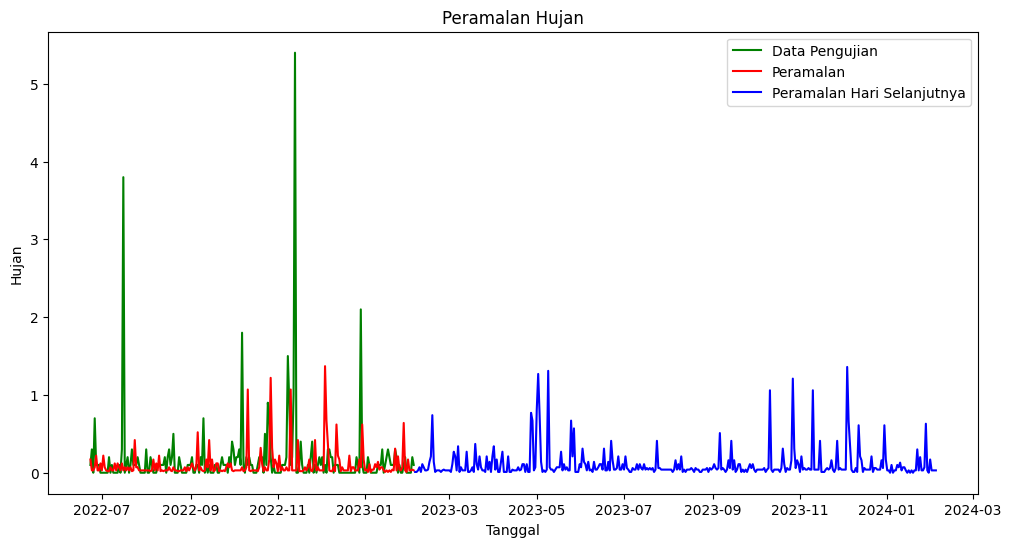

In [ ]:
# Plot hasil peramalan
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data['hujan_900'], label='Data Pengujian', color='green')
plt.plot(forecast_df['hujan_900_model'].index[:227], forecast_df['hujan_900_model'][:227], label='Peramalan', color='red')
plt.plot(forecast_df['hujan_900_model'].index[227:], forecast_df['hujan_900_model'][227:], label='Peramalan Hari Selanjutnya', color='blue')
plt.title('Peramalan Hujan')
plt.xlabel('Tanggal')
plt.ylabel('Hujan')
plt.legend()
plt.show()

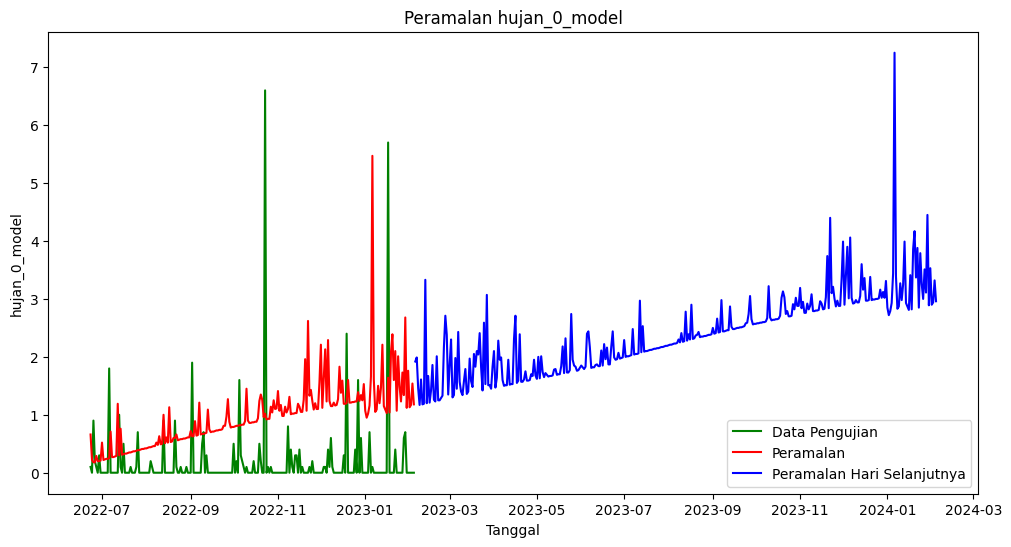

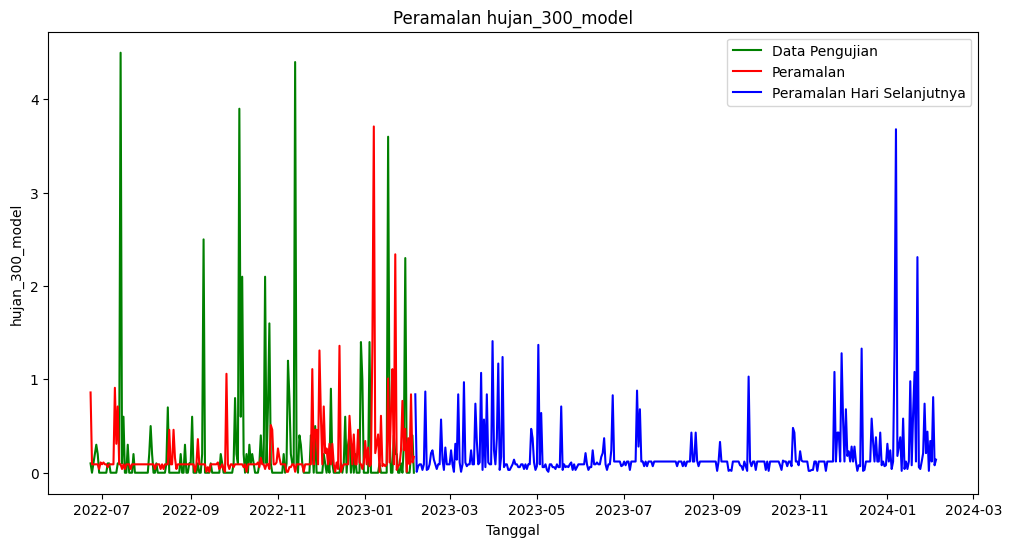

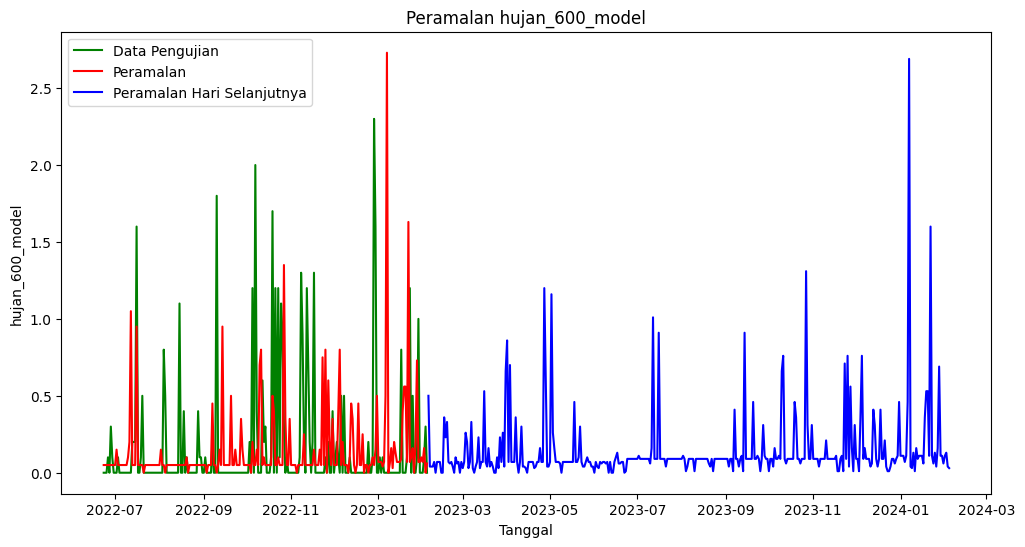

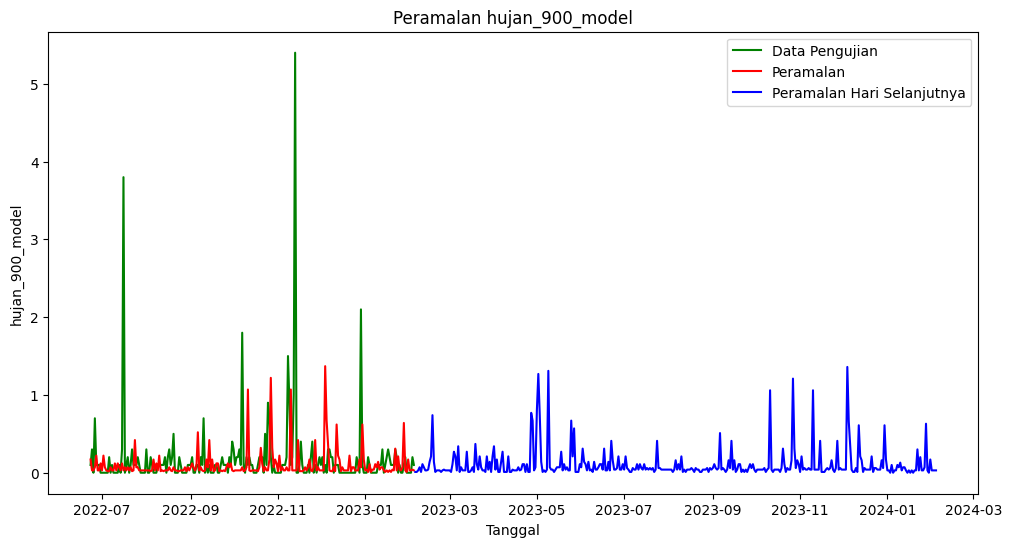

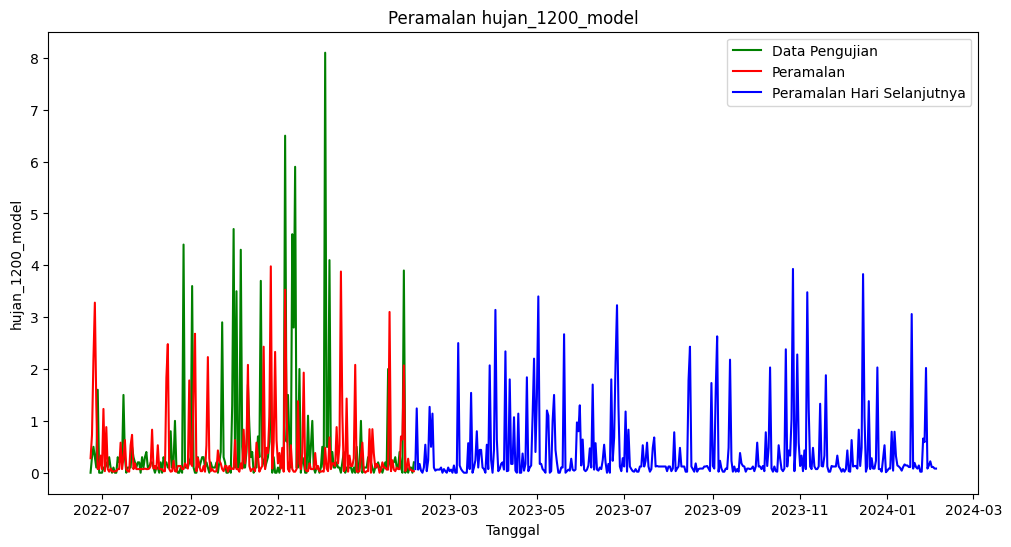

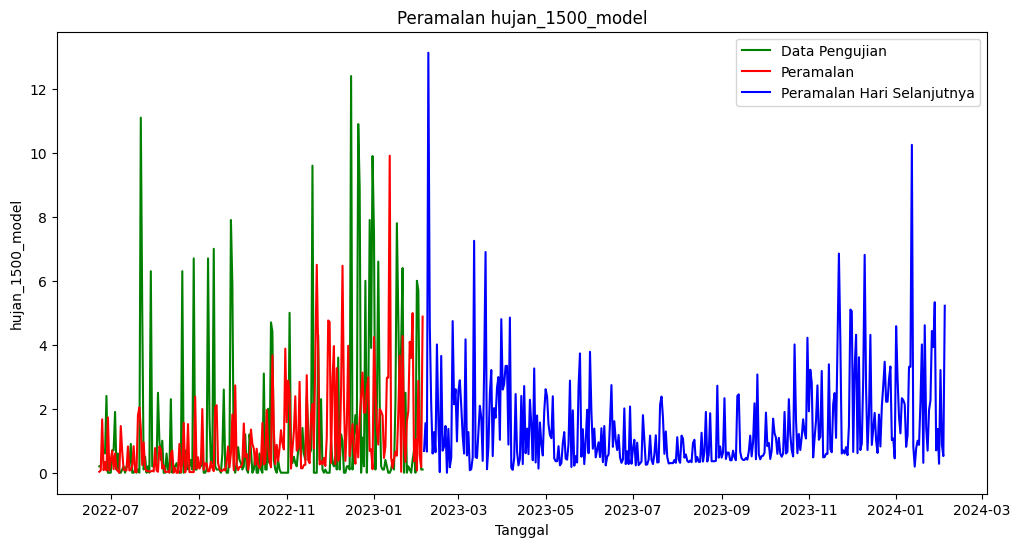

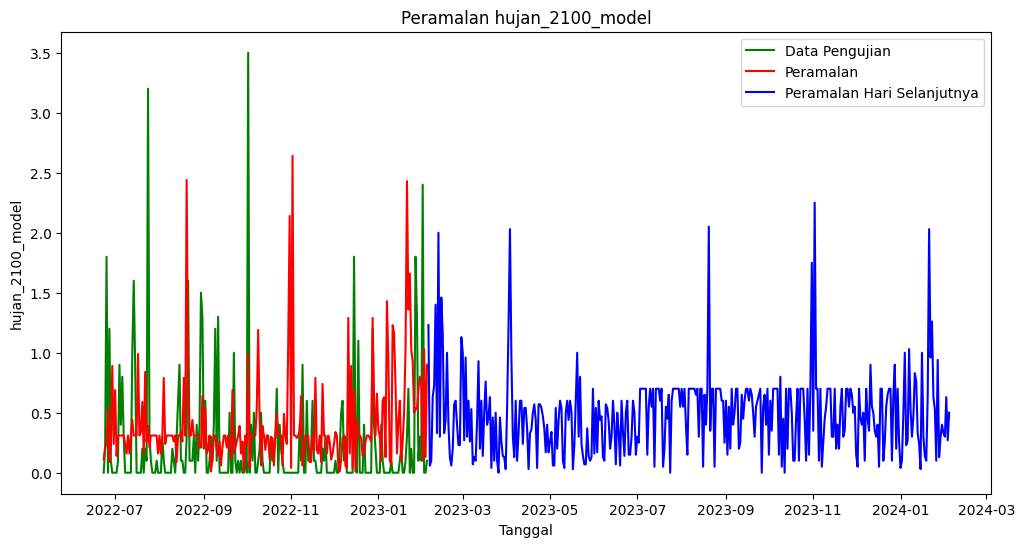

In [ ]:
import matplotlib.pyplot as plt

# Buat peta (mapping) untuk mengaitkan kolom-kolom dari test_data ke forecast_df
column_mapping = {
    'hujan_0': 'hujan_0_model',
    'hujan_300': 'hujan_300_model',
    'hujan_600': 'hujan_600_model',
    'hujan_900': 'hujan_900_model',
    'hujan_1200': 'hujan_1200_model',
    'hujan_1500': 'hujan_1500_model',
    'hujan_2100': 'hujan_2100_model',
    # Tambahkan kolom lainnya sesuai kebutuhan
}

# Loop melalui semua kolom hasil peramalan
for test_column, forecast_column in column_mapping.items():
    plt.figure(figsize=(12, 6))
    plt.plot(test_data.index, test_data[test_column], label='Data Pengujian', color='green')
    plt.plot(forecast_df.index[:227], forecast_df[forecast_column][:227], label='Peramalan', color='red')
    plt.plot(forecast_df.index[227:], forecast_df[forecast_column][227:], label='Peramalan Hari Selanjutnya', color='blue')
    plt.title(f'Peramalan {forecast_column}')
    plt.xlabel('Tanggal')
    plt.ylabel(forecast_column)
    plt.legend()
    plt.show()


## 9. Save Model <a class="anchor" id="9"></a>

In [ ]:
# Fungsi untuk membuat dan menyimpan model ke dalam file pickle
def save_model_to_pickle(model, filename):
    with open(filename, 'wb') as file:
        pickle.dump(model, file)

# Kolom yang ingin dievaluasi
columns_to_evaluate = ['hujan_0', 'hujan_300', 'hujan_600', 'hujan_900', 'hujan_1200', 'hujan_1500', 'hujan_2100']

# Inisialisasi folder untuk menyimpan model
model_folder = 'models/'

# Membuat folder jika belum ada
os.makedirs(model_folder, exist_ok=True)

# Membuat dan menyimpan model untuk setiap kolom
for col in columns_to_evaluate:
    train_column = df[col]
    model = ExponentialSmoothing(train_column, trend='add', seasonal='add', seasonal_periods=365)
    model_fit = model.fit()

    # Menyimpan model ke dalam file pickle
    model_filename = os.path.join(model_folder, col + '_model.pkl')
    save_model_to_pickle(model_fit, model_filename)
    print(f'Model for {col} saved to {model_filename}')

Model for hujan_0 saved to models/hujan_0_model.pkl
Model for hujan_300 saved to models/hujan_300_model.pkl
Model for hujan_600 saved to models/hujan_600_model.pkl
Model for hujan_900 saved to models/hujan_900_model.pkl
Model for hujan_1200 saved to models/hujan_1200_model.pkl
Model for hujan_1500 saved to models/hujan_1500_model.pkl
Model for hujan_2100 saved to models/hujan_2100_model.pkl


In [ ]:
model_dir = '/content/models'
all_models = {}

for file_name in os.listdir(model_dir):
    if file_name.endswith('.pkl'):
        model_name = file_name.split('.')[0]
        with open(os.path.join(model_dir, file_name), 'rb') as model_file:
            model = pickle.load(model_file)
        all_models[model_name] = model

forecast_results = {}

for model_name, model in all_models.items():
    forecast = model.forecast(2 * 350)  # Gantilah dengan metode pengambilan panjang peramalan yang sesuai
    forecast_results[model_name] = forecast

In [ ]:
forecast_df = pd.DataFrame(forecast_results)
forecast_df = abs(forecast_df).round(2)
forecast_df

hujan_2100_model  hujan_300_model  hujan_1200_model  \
2023-02-05              0.99             0.81              0.20   
2023-02-06              0.18             0.02              1.37   
2023-02-07              0.14             0.05              0.07   
2023-02-08              0.39             0.12              0.30   
2023-02-09              0.49             0.12              0.17   
...                      ...              ...               ...   
2024-12-31              0.89             0.15              0.11   
2025-01-01              0.94             0.18              0.08   
2025-01-02              1.14             0.10              0.13   
2025-01-03              1.59             0.30              0.78   
2025-01-04              0.69             0.18              0.13   

            hujan_600_model  hujan_0_model  hujan_900_model  hujan_1500_model  
2023-02-05             0.54           0.48             0.06              0.70  
2023-02-06             0.00           0.55             0.06              1.57  
2023-02-07             0.00           0.02             0.03              0.67  
2023-02-08             0.00           0.28             0.13             13.13  
2023-02-09             0.03           0.15             0.06              4.60  
...                     ...            ...              ...               ...  
2024-12-31             0.05           0.56             0.03              4.78  
2025-01-01             0.03           0.66             0.08              1.70  
2025-01-02             0.05           0.61             0.10              1.28  
2025-01-03             0.00           0.33             0.15              2.03  
2025-01-04             0.05           0.13             0.05              1.75  

[700 rows x 7 columns]

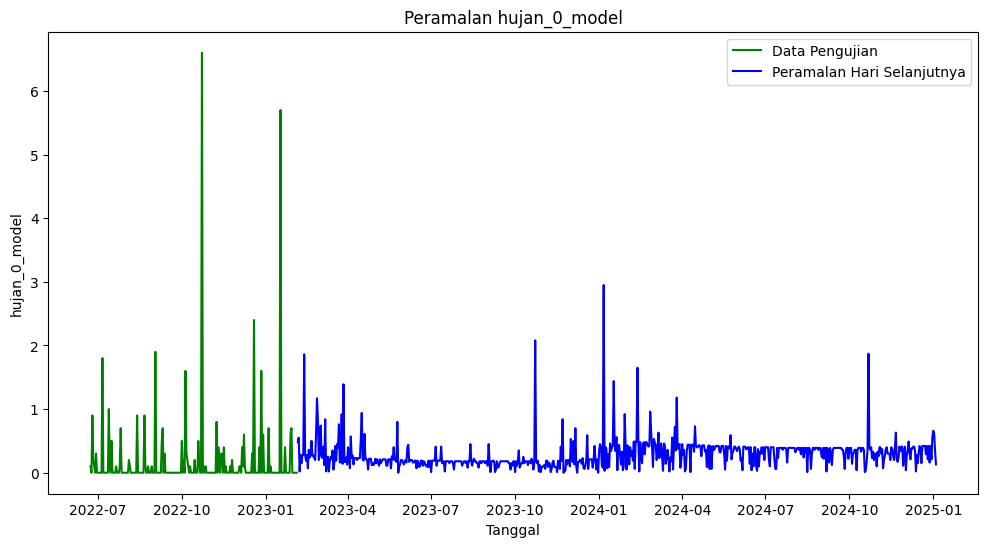

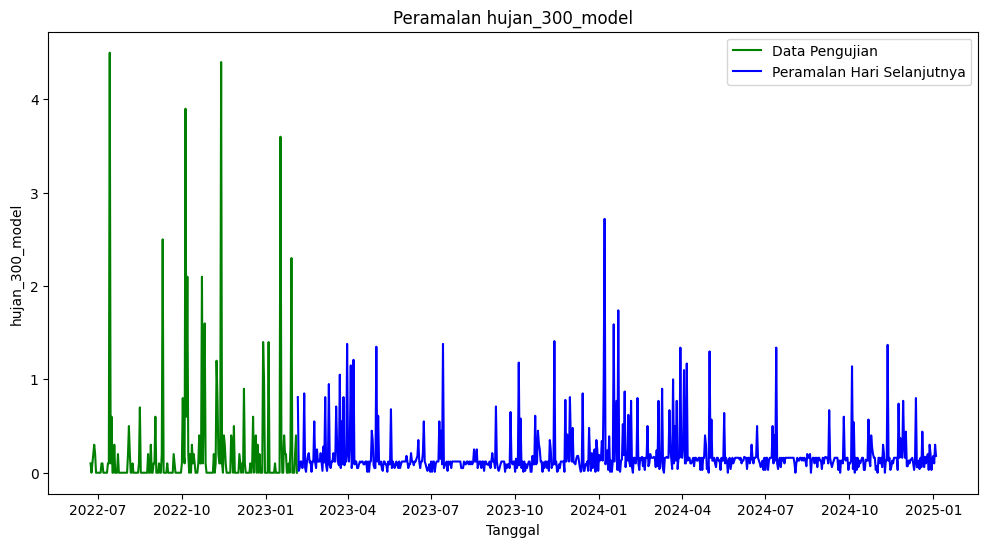

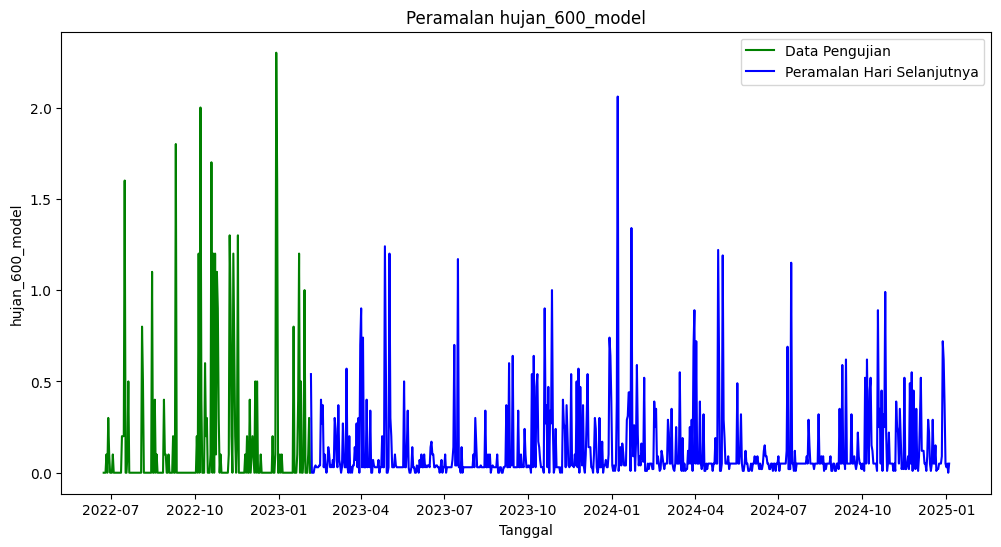

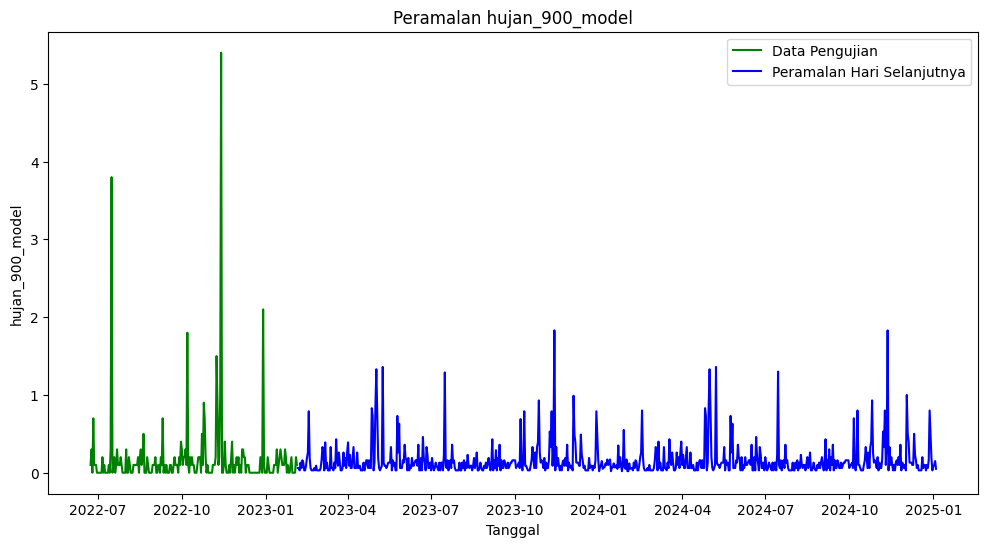

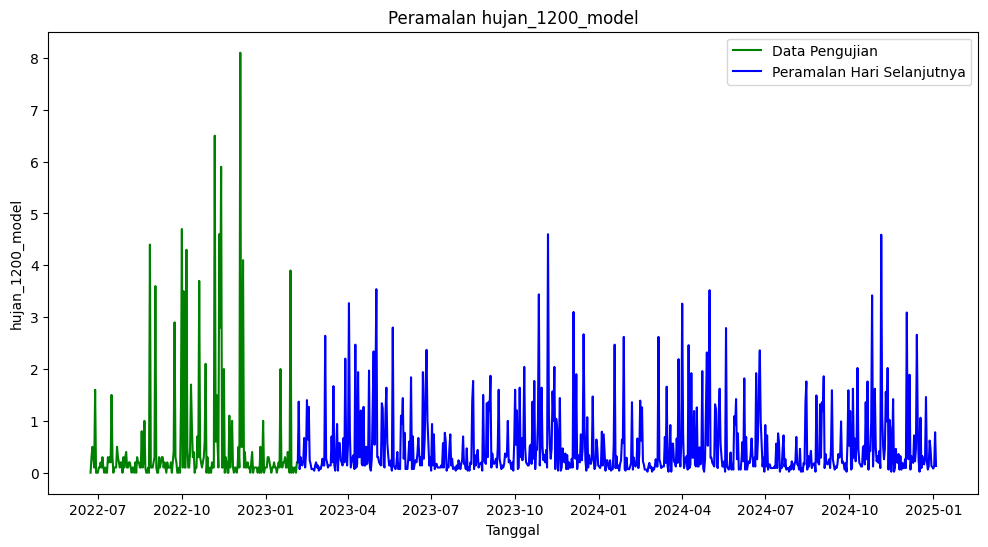

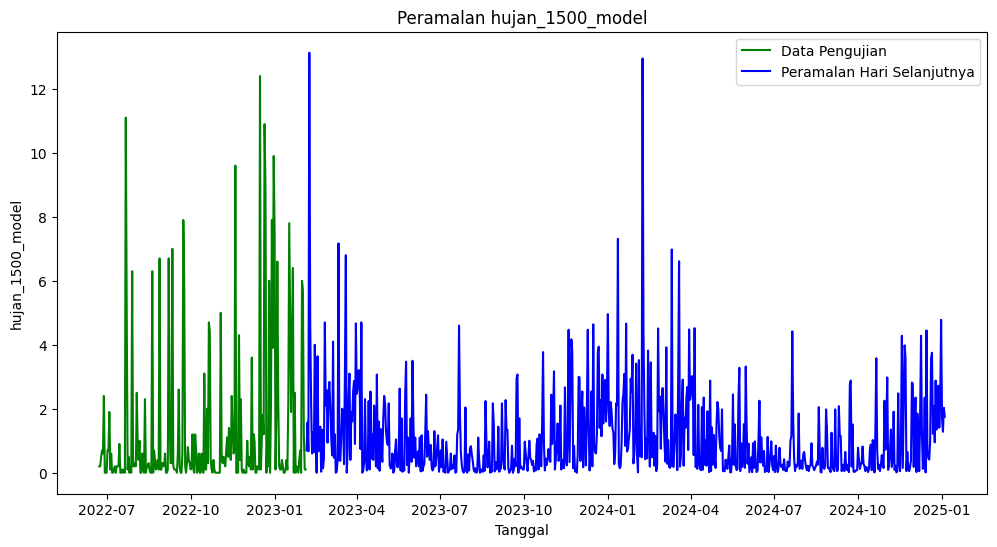

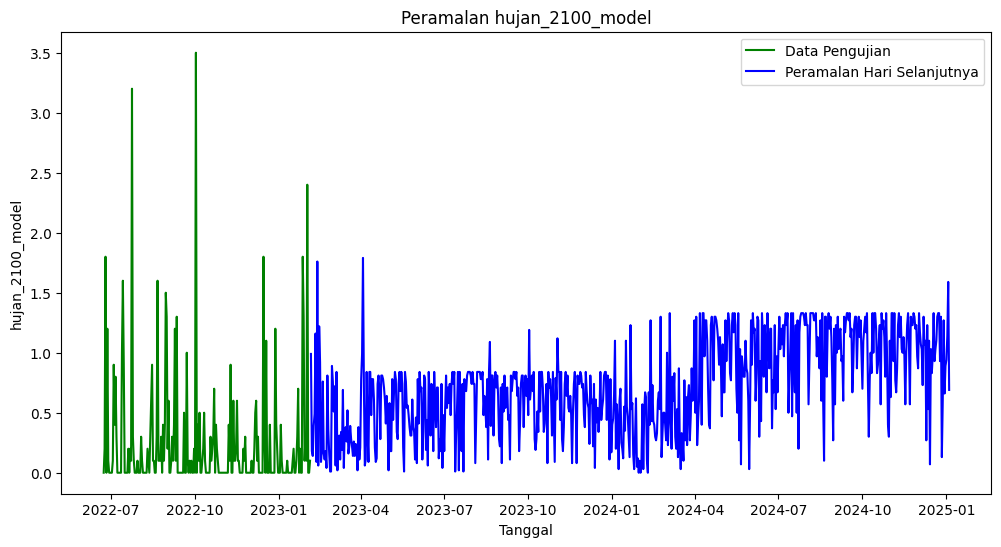

In [ ]:
import matplotlib.pyplot as plt

# Buat peta (mapping) untuk mengaitkan kolom-kolom dari test_data ke forecast_df
column_mapping = {
    'hujan_0': 'hujan_0_model',
    'hujan_300': 'hujan_300_model',
    'hujan_600': 'hujan_600_model',
    'hujan_900': 'hujan_900_model',
    'hujan_1200': 'hujan_1200_model',
    'hujan_1500': 'hujan_1500_model',
    'hujan_2100': 'hujan_2100_model',
    # Tambahkan kolom lainnya sesuai kebutuhan
}

# Loop melalui semua kolom hasil peramalan
for test_column, forecast_column in column_mapping.items():
    plt.figure(figsize=(12, 6))
    plt.plot(test_data.index, test_data[test_column], label='Data Pengujian', color='green')
    plt.plot(forecast_df.index, forecast_df[forecast_column], label='Peramalan Hari Selanjutnya', color='blue')
    plt.title(f'Peramalan {forecast_column}')
    plt.xlabel('Tanggal')
    plt.ylabel(forecast_column)
    plt.legend()
    plt.show()
